In [2]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from itertools import zip_longest
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

from scripts import geocoder
import geopandas as gpd

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D
from scipy.interpolate import make_interp_spline
import matplotlib.cm as cm

from scripts import network
import networkx as nx

world = gpd.read_file('scripts/ne_10m_admin_0_countries.zip')
world = world[world['ADMIN'] != 'Antarctica']

from IPython.display import clear_output
pd.set_option('future.no_silent_downcasting', True)

/Users/p.sitthirat/Desktop/Research/03_MedEd & Student's Project/SNA/MedEd - SNA/.venv/lib/python3.13/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
/Users/p.sitthirat/Desktop/Research/03_MedEd & Student's Project/SNA/MedEd - SNA/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-06 18:50:35 INFO: Downloaded file to /Users/p.sitthirat/stanza_resources/resources.json
2025-04-06 18:50:35 INFO: Downloading default packages for language: en (English) ...
2025-04-06 18:50:36 INFO: File exists: /Users/p.sitthirat/stanza_resources/en/default.zip
2025-04-06 18:50:38 INFO: Finished downloading models an

In [88]:
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Arial"],
    "axes.edgecolor": "black",
    "axes.linewidth": 1,
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.major.size": 4,
    "ytick.major.size": 4,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "legend.fontsize": 10,
    "figure.facecolor": "white",
    "axes.facecolor": "white"
})

### Data processing

In [10]:
# Load dataset
scopus_df = pd.DataFrame()

for journal in ['AcadMed', 'AdvHealth', 'BMC', 'MedEd', 'MedTeach']:
    df = pd.read_csv(f'data/journal/{journal}.csv')
    scopus_df = pd.concat([scopus_df, df], ignore_index=True)

# Filter only article and reviews
scopus_df = scopus_df[scopus_df['Document Type'].isin(['Article', 'Review'])]

# Change 'source title' to be more convenient
scopus_df['Source title'] = scopus_df['Source title'].apply(lambda x: 'Academic Medicine' if x == 'Academic medicine : journal of the Association of American Medical Colleges' else x)
scopus_df['Source title'] = scopus_df['Source title'].apply(lambda x: 'BMC Medical Education' if x == 'BMC medical education' else x)
scopus_df['Source title'] = scopus_df['Source title'].apply(lambda x: 'Medical Education' if x == 'Medical education' else x)
scopus_df['Source title'] = scopus_df['Source title'].apply(lambda x: 'Medical Teacher' if x == 'Medical teacher' else x)

display(scopus_df.head())

,Authors,Author full names,Author(s) ID,Title,Year,Source title,Volume,Issue,Art. No.,Page start,...,DOI,Link,Affiliations,Authors with affiliations,Abstract,Document Type,Publication Stage,Open Access,Source,EID
0,Jacobson C.E.; Griffith K.A.; Krenz C.; Jones ...,"Jacobson, Clare E. (57202204199); Griffith, Ke...",57202204199; 7005236782; 57189401106; 56164498...,The Disproportionate Effects of the COVID-19 P...,2024,Academic Medicine,99.0,12,NaN,1396,...,10.1097/ACM.0000000000005681,https://www.scopus.com/inward/record.uri?eid=2...,"University of Michigan, Ann Arbor, MI, United ...","Jacobson C.E., University of Michigan, Ann Arb...",Purpose To understand time allocation of a nat...,Article,Final,NaN,Scopus,2-s2.0-85210764408
1,Lin G.L.; Priest K.C.; Sossenheimer P.H.; Pal R.,"Lin, Grant L. (57193863317); Priest, Kelsey C....",57193863317; 54881358700; 57204195947; 5719367...,Contextualizing the Resurgence of U.S. Housest...,2024,Academic Medicine,99.0,10,NaN,1054,...,10.1097/ACM.0000000000005816,https://www.scopus.com/inward/record.uri?eid=2...,"Stanford University, School of Medicine, Palo ...","Lin G.L., Stanford University, School of Medic...",There is a growing trend of resident and fello...,Review,Final,NaN,Scopus,2-s2.0-85199189838
2,Pang E.M.,"Pang, Emily M. (57218193328)",57218193328,Hippocrates: An Oath in Entering Medicine and ...,2024,Academic Medicine,99.0,12,NaN,1344,...,10.1097/ACM.0000000000005477,https://www.scopus.com/inward/record.uri?eid=2...,NaN,NaN,[No abstract available],Article,Final,All Open Access; Bronze Open Access,Scopus,2-s2.0-85211393430
3,Carraccio C.; Schumacher D.J.; Ten Cate O.,"Carraccio, Carol (35552747700); Schumacher, Da...",35552747700; 35976692600; 16317722200,Reimagining Initial Certification as a Process...,2024,Academic Medicine,99.0,10,NaN,1083,...,10.1097/ACM.0000000000005797,https://www.scopus.com/inward/record.uri?eid=2...,"American Board of Pediatrics, Chapel Hill, NC,...","Carraccio C., American Board of Pediatrics, Ch...","In the United States, initial board certificat...",Article,Final,All Open Access; Bronze Open Access,Scopus,2-s2.0-85206304423
5,Bullock J.L.; McClintock A.H.; Abe R.; Boos M....,"Bullock, Justin L. (57215313087); McClintock, ...",57215313087; 57193319314; 58670645100; 5583170...,"Our House Won't Rebuild Itself: Peace, Love, a...",2024,Academic Medicine,99.0,12,NaN,S5,...,10.1097/ACM.0000000000005861,https://www.scopus.com/inward/record.uri?eid=2...,"Department of Medicine, Division of Nephrology...","Bullock J.L., Department of Medicine, Division...","Graduate medical education (GME), the period o...",Article,Final,All Open Access; Bronze Open Access,Scopus,2-s2.0-85203066738


In [11]:
# Splitting the "Authors" and "Author full names" columns
df = scopus_df.copy()
df["Authors List"] = df["Authors"].str.split("; ")
df["Author Full Names List"] = df["Author full names"].str.split("; ")
df["Authors with affiliations"] = df["Authors with affiliations"].str.replace(" amp;", "", regex=False)

affiliation_lists = []
for _, row in df.iterrows():
    affil_text = row["Authors with affiliations"]
    
    # Safely handle missing affiliations
    if isinstance(affil_text, str) and row["Authors List"]:
        for author in row["Authors List"]:
            affil_text = affil_text.replace(author, "||")
        affil_split = [
            None if part.strip() in {";"} else part.lstrip(", ").strip()
            for part in affil_text.split("||")
        ][1:]
        affiliation_lists.append(affil_split)
    else:
        affiliation_lists.append([])  # fallback for missing data

df["Author Affiliations List"] = affiliation_lists

# List to store per-row dictionaries
per_row_author_mappings_restructured = []

# Iterating through each row in the dataset
for authors, full_names, affiliations in zip(df["Authors List"], df["Author Full Names List"], df["Author Affiliations List"]):
    row_author_info = {}

    # Ensure lists exist and full_names match authors (we'll handle affiliation mismatches)
    if isinstance(authors, list) and isinstance(full_names, list) and len(authors) == len(full_names):
        
        for author, full_name, affiliation in zip_longest(authors, full_names, affiliations, fillvalue=None):
            if full_name:
                author_id = full_name.split("(")[-1].strip(")")
                cleaned_affil = affiliation.rstrip(";").strip() if affiliation else None
                row_author_info[author_id] = {
                    "Author name": author.strip() if author else None,
                    "Affiliation": cleaned_affil
                }

    per_row_author_mappings_restructured.append(row_author_info)

# Add the updated dictionary to the DataFrame
df["Author ID Mapping"] = per_row_author_mappings_restructured

df.drop_duplicates(subset='DOI', keep='first')

# Display updated DataFrame
scopus_df = df.copy()
display(scopus_df.head())

,Authors,Author full names,Author(s) ID,Title,Year,Source title,Volume,Issue,Art. No.,Page start,...,Abstract,Document Type,Publication Stage,Open Access,Source,EID,Authors List,Author Full Names List,Author Affiliations List,Author ID Mapping
0,Jacobson C.E.; Griffith K.A.; Krenz C.; Jones ...,"Jacobson, Clare E. (57202204199); Griffith, Ke...",57202204199; 7005236782; 57189401106; 56164498...,The Disproportionate Effects of the COVID-19 P...,2024,Academic Medicine,99.0,12,NaN,1396,...,Purpose To understand time allocation of a nat...,Article,Final,NaN,Scopus,2-s2.0-85210764408,"[Jacobson C.E., Griffith K.A., Krenz C., Jones...","[Jacobson, Clare E. (57202204199), Griffith, K...","[University of Michigan, Ann Arbor, MI, United...",{'57202204199': {'Author name': 'Jacobson C.E....
1,Lin G.L.; Priest K.C.; Sossenheimer P.H.; Pal R.,"Lin, Grant L. (57193863317); Priest, Kelsey C....",57193863317; 54881358700; 57204195947; 5719367...,Contextualizing the Resurgence of U.S. Housest...,2024,Academic Medicine,99.0,10,NaN,1054,...,There is a growing trend of resident and fello...,Review,Final,NaN,Scopus,2-s2.0-85199189838,"[Lin G.L., Priest K.C., Sossenheimer P.H., Pal...","[Lin, Grant L. (57193863317), Priest, Kelsey C...","[Stanford University, School of Medicine, Palo...","{'57193863317': {'Author name': 'Lin G.L.', 'A..."
2,Pang E.M.,"Pang, Emily M. (57218193328)",57218193328,Hippocrates: An Oath in Entering Medicine and ...,2024,Academic Medicine,99.0,12,NaN,1344,...,[No abstract available],Article,Final,All Open Access; Bronze Open Access,Scopus,2-s2.0-85211393430,[Pang E.M.],"[Pang, Emily M. (57218193328)]",[],"{'57218193328': {'Author name': 'Pang E.M.', '..."
3,Carraccio C.; Schumacher D.J.; Ten Cate O.,"Carraccio, Carol (35552747700); Schumacher, Da...",35552747700; 35976692600; 16317722200,Reimagining Initial Certification as a Process...,2024,Academic Medicine,99.0,10,NaN,1083,...,"In the United States, initial board certificat...",Article,Final,All Open Access; Bronze Open Access,Scopus,2-s2.0-85206304423,"[Carraccio C., Schumacher D.J., Ten Cate O.]","[Carraccio, Carol (35552747700), Schumacher, D...","[American Board of Pediatrics, Chapel Hill, NC...",{'35552747700': {'Author name': 'Carraccio C.'...
5,Bullock J.L.; McClintock A.H.; Abe R.; Boos M....,"Bullock, Justin L. (57215313087); McClintock, ...",57215313087; 57193319314; 58670645100; 5583170...,"Our House Won't Rebuild Itself: Peace, Love, a...",2024,Academic Medicine,99.0,12,NaN,S5,...,"Graduate medical education (GME), the period o...",Article,Final,All Open Access; Bronze Open Access,Scopus,2-s2.0-85203066738,"[Bullock J.L., McClintock A.H., Abe R., Boos M...","[Bullock, Justin L. (57215313087), McClintock,...","[Department of Medicine, Division of Nephrolog...",{'57215313087': {'Author name': 'Bullock J.L.'...


In [12]:
rows = []

for _, row in scopus_df.iterrows():
    doi = row['DOI']
    author_dict = row['Author ID Mapping']
    journal = row['Source title']
    year = row['Year']
    total_authors = len(author_dict)

    i = 1    
    for author_id, details in author_dict.items():
        position = (
            'First Author' if i == 1 
            else 'Last Author' if i == total_authors and i > 1 
            else 'Co-Author'
        )
        rows.append({
            'DOI': doi,
            'Journal': journal,
            'Year': year,
            'Author ID': author_id,
            'Author name': details.get('Author name'),
            'Affiliation': details.get('Affiliation'),
            'Position': position
        })
        i += 1  # increment i to move to the next author

# Create new DataFrame
authors_df = pd.DataFrame(rows)
display(authors_df.head())

,DOI,Journal,Year,Author ID,Author name,Affiliation,Position
0,10.1097/ACM.0000000000005681,Academic Medicine,2024,57202204199,Jacobson C.E.,"University of Michigan, Ann Arbor, MI, United ...",First Author
1,10.1097/ACM.0000000000005681,Academic Medicine,2024,7005236782,Griffith K.A.,"Center for Cancer Biostatistics, University of...",Co-Author
2,10.1097/ACM.0000000000005681,Academic Medicine,2024,57189401106,Krenz C.,"Boston University, Boston, MA, United States",Co-Author
3,10.1097/ACM.0000000000005681,Academic Medicine,2024,56164498300,Jones R.D.,Center for Bioethics & Social Sciences in Medi...,Co-Author
4,10.1097/ACM.0000000000005681,Academic Medicine,2024,57219868320,Cutter C.M.,"University of Michigan, Ann Arbor, MI, United ...",Co-Author


In [13]:
# Load and clean geo_df
geo_df = pd.read_csv('output/aff_geocoded.csv')
geo_df.set_index('Unnamed: 0', inplace=True)

# Print original length
print("Original geo_df length:", len(geo_df))

# Drop duplicate affiliations and reset index
geo_df = geo_df.drop_duplicates(subset='Affiliation', keep='first').reset_index(drop=True)
print("After dropping duplicates:", len(geo_df))

# Filter geo_df to keep only affiliations found in authors_df and reset index
geo_df = geo_df[geo_df['Affiliation'].isin(authors_df['Affiliation'])].reset_index(drop=True)
print("After check with authors_df:", len(geo_df))

# Display the first 50 rows
display(geo_df.head())

geo_df.to_csv('output/aff_geocoded.csv', index=True)

Original geo_df length: 38291
After dropping duplicates: 38291
After check with authors_df: 38291


,Affiliation,Location,Organization,Latitude,Longitude,Country,Continent
0,"University of Michigan, Ann Arbor, MI, United ...","Ann Arbor, MI, United States",University of Michigan,42.294214,-83.710039,USA,North America
1,"Center for Cancer Biostatistics, University of...","Ann Arbor, MI, United States","Center for Cancer Biostatistics, University of...",42.281372,-83.748462,USA,North America
2,"Boston University, Boston, MA, United States","Boston, MA, United States",Boston University,42.350422,-71.103228,USA,North America
3,Center for Bioethics & Social Sciences in Medi...,"Ann Arbor, MI, United States",Center for Bioethics & Social Sciences in Medi...,42.281372,-83.748462,USA,North America
4,"Department of Radiation Oncology, Michigan Med...","Ann Arbor, MI, United States","Department of Radiation Oncology, Michigan Med...",42.281372,-83.748462,USA,North America


In [14]:
# Create a copy of the DataFrame
df = authors_df.copy()

# Extract unique affiliations
unique_affiliations = df['Affiliation'].dropna().unique()
print(f"Total Unique Affiliations to Process: {len(unique_affiliations)}")

# Load existing progress if available
temp_file = "output/aff_geocoded_temp.csv"
final_file = "output/aff_geocoded.csv"
if os.path.exists(temp_file):
    geo_df = pd.read_csv(temp_file, index_col=0)
    geo_df = geo_df.dropna().reset_index(drop=True)
    processed_affiliations = set(geo_df["Affiliation"])
    print(f"Resuming from previous progress: {len(processed_affiliations)} affiliations already processed.")
elif os.path.exists(final_file):
    geo_df = pd.read_csv(final_file, index_col=0)
    geo_df = geo_df.dropna().reset_index(drop=True)
    processed_affiliations = set(geo_df["Affiliation"])
    print(f"Resuming from previous progress: {len(processed_affiliations)} affiliations already processed.")
else:
    geo_df = pd.DataFrame()
    processed_affiliations = set()

geo_results = []

# Iterate through unique affiliations with progress bar
for i, affil in enumerate(tqdm(unique_affiliations)):
    
    if affil in processed_affiliations:
        continue  # Skip already-processed affiliations
    
    location, organization = geocoder.extract_location(affil)
    
    if location is None and organization is None:
        lat, lon, country, continent = None, None, None, None
    else:
        # Try geocoding organization first, fallback to location
        lat, lon = None, None
        if organization:
            lat, lon = geocoder.extract_coordination(organization)
            if lat is None and lon is None and location:
                lat, lon = geocoder.extract_coordination(location)
                if lat is None and lon is None:
                    lat, lon = geocoder.extract_coordination(geocoder.extract_last_parts(location,3))
                    if lat is None and lon is None:
                        lat, lon = geocoder.extract_coordination(geocoder.extract_last_parts(location,2))
                        if lat is None and lon is None:
                            lat, lon = geocoder.extract_coordination(geocoder.extract_last_parts(location,1))
            
            if location is None and lat and lon:
                location = geocoder.extract_city(lat, lon)
                
        else:
            lat, lon = geocoder.extract_coordination(location)
            if lat is None and lon is None:
                lat, lon = geocoder.extract_coordination(geocoder.extract_last_parts(location,3))
                if lat is None and lon is None:
                    lat, lon = geocoder.extract_coordination(geocoder.extract_last_parts(location,2))
                    if lat is None and lon is None:
                        lat, lon = geocoder.extract_coordination(geocoder.extract_last_parts(location,1))

        country, continent = None, None
        if lat and lon:
            country, continent = geocoder.extract_country(world, lat, lon) 

    geo_results.append({
        "Affiliation": affil,
        "Location": location,
        "Organization": organization,
        "Latitude": lat,
        "Longitude": lon,
        "Country": country,
        "Continent": continent
    })
    
    # Save progress every 100 records
    if len(geo_results) % 100 == 0:
        print(f"Saving progress at {len(geo_results)} new records...")
        temp_df = pd.DataFrame(geo_results)
        combined = pd.concat([geo_df, temp_df], ignore_index=True)
        combined.to_csv(temp_file, index=True)

clear_output()

# Create a DataFrame from the final results
final_df = pd.concat([geo_df, pd.DataFrame(geo_results)], ignore_index=True)
condition = final_df['Location'].isna() & final_df['Organization'].isna()
final_df.loc[condition, ['Latitude', 'Longitude', 'Country', 'Continent']] = None
final_df.to_csv("output/aff_geocoded.csv", index=True)
print("Geocoding complete. Final file saved.")

# Remove the temporary file
if os.path.exists(temp_file):
    os.remove(temp_file)
    print("Temporary file deleted.")

# Merge to authors_df
authors_merge_df = authors_df.merge(final_df[['Affiliation', 'Location', 'Organization', 'Latitude', 'Longitude', 'Country', 'Continent']], on='Affiliation', how='left')
display(authors_merge_df.head())

Geocoding complete. Final file saved.
Temporary file deleted.


,DOI,Journal,Year,Author ID,Author name,Affiliation,Position,Location,Organization,Latitude,Longitude,Country,Continent
0,10.1097/ACM.0000000000005681,Academic Medicine,2024,57202204199,Jacobson C.E.,"University of Michigan, Ann Arbor, MI, United ...",First Author,"Ann Arbor, MI, United States",University of Michigan,42.294214,-83.710039,USA,North America
1,10.1097/ACM.0000000000005681,Academic Medicine,2024,7005236782,Griffith K.A.,"Center for Cancer Biostatistics, University of...",Co-Author,"Ann Arbor, MI, United States","Center for Cancer Biostatistics, University of...",42.281372,-83.748462,USA,North America
2,10.1097/ACM.0000000000005681,Academic Medicine,2024,57189401106,Krenz C.,"Boston University, Boston, MA, United States",Co-Author,"Boston, MA, United States",Boston University,42.350422,-71.103228,USA,North America
3,10.1097/ACM.0000000000005681,Academic Medicine,2024,56164498300,Jones R.D.,Center for Bioethics & Social Sciences in Medi...,Co-Author,"Ann Arbor, MI, United States",Center for Bioethics & Social Sciences in Medi...,42.281372,-83.748462,USA,North America
4,10.1097/ACM.0000000000005681,Academic Medicine,2024,57219868320,Cutter C.M.,"University of Michigan, Ann Arbor, MI, United ...",Co-Author,"Ann Arbor, MI, United States",University of Michigan,42.294214,-83.710039,USA,North America


In [19]:
df = authors_merge_df.copy()

final_file = "output/aff_geocoded.csv"
geo_df = geo_df.dropna().reset_index(drop=True)
geo_lookup = geo_df[['Affiliation', 'Location', 'Organization', 'Latitude', 'Longitude', 'Country', 'Continent']]

cols_geo = ['Location', 'Organization', 'Latitude', 'Longitude', 'Country', 'Continent']

print(f'Null country ramain: {len(df[(df['Country'].isna()) & (~df['Affiliation'].isna())])} rows')
print('Imputing with Author ID...')

grouped_id = df.groupby('Author ID')

for author_id, group in grouped_id:
    missing_group = group[group[cols_geo].isna().any(axis=1)]
    if len(missing_group) > 1:
        for col in cols_geo:
            if group[col].isna().any():
                mode = group[col].mode(dropna=True)
                if not mode.empty:
                    # Update the original df using the index of the group
                    df.loc[group.index, col] = df.loc[group.index, col].fillna(mode.iloc[0])


print(f'Null country ramain: {len(df[(df['Country'].isna()) & (~df['Affiliation'].isna())])} rows')
print('Imputing with DOI...')

grouped_doi = df.groupby('DOI')

for doi, group in grouped_doi:
    missing_group = group[group[cols_geo].isna().any(axis=1)]
    if len(missing_group) > 1:
        for col in cols_geo:
            if group[col].isna().any():
                mode = group[col].mode(dropna=True)
                if not mode.empty:
                    # Update the original df using the index of the group
                    df.loc[group.index, col] = df.loc[group.index, col].fillna(mode.iloc[0])
                    
print(f'Null country ramain: {len(df[(df['Country'].isna()) & (~df['Affiliation'].isna())])} rows')
print('Imputing with matching the organization with existing list...')

df_formatch = df[(df['Country'].isna()) & (~df['Affiliation'].isna()) & (~df['Organization'].isna())]

# Loop over unmatched orgs
for idx, row in df_formatch.iterrows():
    org_to_match = row['Organization']
    
    # Use fuzzy matching to find best match
    result = process.extractOne(org_to_match, geo_lookup['Affiliation'], scorer=fuzz.token_set_ratio)
    
    if result is not None:
        best_match, score, _ = result  # Ignore the index
        if score >= 95:
            matched_row = geo_lookup[geo_lookup['Affiliation'] == best_match].mode().iloc[0]
            for col in cols_geo:
                df.at[idx, col] = matched_row[col]

print(f'Null country ramain: {len(df[(df['Country'].isna()) & (~df['Affiliation'].isna())])} rows')
print('Imputing with manual edits...')

# Load updated CSV
updated_geocode = pd.read_csv('output/missing_geocode_edited.csv', index_col=0)

# Update relevant columns in the original DataFrame
for col in cols_geo:
    if col in updated_geocode.columns:
        df.loc[updated_geocode.index, col] = updated_geocode[col]
    
print(f'Null country ramain: {len(df[(df['Country'].isna()) & (~df['Affiliation'].isna())])} rows')

df_foranalyse = df.copy()
df_foranalyse.to_csv('output/publications.csv')
display(df_foranalyse)

Null country ramain: 144 rows
Imputing with Author ID...
Null country ramain: 110 rows
Imputing with DOI...
Null country ramain: 39 rows
Imputing with matching the organization with existing list...
Null country ramain: 10 rows
Imputing with manual edits...
Null country ramain: 0 rows


,DOI,Journal,Year,Author ID,Author name,Affiliation,Position,Location,Organization,Latitude,Longitude,Country,Continent
0,10.1097/ACM.0000000000005681,Academic Medicine,2024,57202204199,Jacobson C.E.,"University of Michigan, Ann Arbor, MI, United ...",First Author,"Ann Arbor, MI, United States",University of Michigan,42.294214,-83.710039,USA,North America
1,10.1097/ACM.0000000000005681,Academic Medicine,2024,7005236782,Griffith K.A.,"Center for Cancer Biostatistics, University of...",Co-Author,"Ann Arbor, MI, United States","Center for Cancer Biostatistics, University of...",42.281372,-83.748462,USA,North America
2,10.1097/ACM.0000000000005681,Academic Medicine,2024,57189401106,Krenz C.,"Boston University, Boston, MA, United States",Co-Author,"Boston, MA, United States",Boston University,42.350422,-71.103228,USA,North America
3,10.1097/ACM.0000000000005681,Academic Medicine,2024,56164498300,Jones R.D.,Center for Bioethics & Social Sciences in Medi...,Co-Author,"Ann Arbor, MI, United States",Center for Bioethics & Social Sciences in Medi...,42.281372,-83.748462,USA,North America
4,10.1097/ACM.0000000000005681,Academic Medicine,2024,57219868320,Cutter C.M.,"University of Michigan, Ann Arbor, MI, United ...",Co-Author,"Ann Arbor, MI, United States",University of Michigan,42.294214,-83.710039,USA,North America
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70273,10.3109/0142159X.2014.932899,Medical Teacher,2015,55658781300,Sinha Y.,"Keele University, United Kingdom, University H...",Last Author,"United Kingdom, North Staffordshire, Godwin Wa...","Keele University, University Hospital",52.802742,-1.629917,GBR,Europe
70274,10.3109/0142159X.2014.923564,Medical Teacher,2015,18436743400,Fairbank C.,"Medical Education Unit, Melbourne Medical Scho...",First Author,"Level 7, Parkville, VIC, Australia","Medical Education Unit, Melbourne Medical Scho...",-37.787115,144.951553,AUS,Oceania
70275,10.3109/0142159X.2014.923564,Medical Teacher,2015,35424440300,Reid K.,"Medical Education Unit, Melbourne Medical Scho...",Co-Author,"Level 7, Parkville, VIC, Australia","Medical Education Unit, Melbourne Medical Scho...",-37.787115,144.951553,AUS,Oceania
70276,10.3109/0142159X.2014.923564,Medical Teacher,2015,56458793700,Minzenmay K.,"Medical Education Unit, Melbourne Medical Scho...",Last Author,"Level 7, Parkville, VIC, Australia","Medical Education Unit, Melbourne Medical Scho...",-37.787115,144.951553,AUS,Oceania


### Analysis

1. Overall network across a decade

In [13]:
df_foranalyse = pd.read_csv('output/authors.csv')
country_gr = pd.read_csv('data/country_group.csv')

def get_position(positions):
    return 'First Author' if 'First Author' in positions.values else 'Co-author'

df_grouped = df_foranalyse[df_foranalyse['Author name'] != 'Anonymous'].groupby('Author ID').agg({
    'Position': get_position,
    'Country': 'first',
    'Continent': 'first',
    'Author name': 'first',
    'Organization': 'first'
}).reset_index()

df_grouped = df_grouped.merge(country_gr[['Code', 'Region', 'Income group']], left_on='Country', right_on='Code')

display(df_grouped.head())

df_grouped.to_csv('output/authors.csv')

,Author ID,Position,Country,Continent,Author name,Organization,Code,Region,Income group
0,6503867142,Co-author,USA,North America,Nassery N.,"General Internal Medicine, Johns Hopkins Bayvi...",USA,North America,High income
1,6503873312,Co-author,USA,North America,Wyskiel R.,Armstrong Institute for Patient Safety and Qua...,USA,North America,High income
2,6503895771,Co-author,USA,North America,Tropello S.,Armstrong Institute for Patient Safety and Qua...,USA,North America,High income
3,6503898246,First Author,IRN,Asia,Changiz T.,"Department of Medical Education, Medical Educa...",IRN,Middle East & North Africa,Upper middle income
4,6503903582,Co-author,GHA,Africa,Srofenyoh E.,Greater Accra Regional Hospital,GHA,Sub-Saharan Africa,Lower middle income


In [6]:
df_foranalyse = pd.read_csv('output/publications.csv')

results = pd.DataFrame()
G_all = nx.Graph()

for year in range(2015, 2025):
    
    # Filter only the data for the current year
    df_year = df_foranalyse[df_foranalyse['Year'] == year]

    # Use the existing function to construct the graph for this year
    G_year = network.network_coauthorship(df_year, 'Author ID')

    # Merge G_year into G_all
    for u, v, data in G_year.edges(data=True):
        if G_all.has_edge(u, v):
            G_all[u][v]['weight'] += data['weight']
        else:
            G_all.add_edge(u, v, weight=data['weight'])

    for node, data in G_year.nodes(data=True):
        if node not in G_all:
            G_all.add_node(node)
        for attr, value in data.items():
            G_all.nodes[node][attr] = value

    result = network.network_params(df_year, G_all)
    results = pd.concat([results, result], ignore_index=True)
    
    print(f'Year {year} network analysed.')


display(results)

Year 2015 network analysed.
Year 2016 network analysed.
Year 2017 network analysed.
Year 2018 network analysed.
Year 2019 network analysed.
Year 2020 network analysed.
Year 2021 network analysed.
Year 2022 network analysed.
Year 2023 network analysed.
Year 2024 network analysed.


,None,No of Publications,Single Author,Single Country,Nodes,Edges,Density,Average Clustering,Average Degree,Max Degree,Top Degree Centrality,Top Betweenness Centrality,Top Closeness Centrality,Top Eigenvector Centrality
0,None,883,95,626,3342,16119,0.002887,0.909385,9.646320,119,0.035618,0.018488,0.068551,0.095455
1,None,963,91,741,6446,27911,0.001344,0.897482,8.659944,128,0.019860,0.055765,0.115436,0.095530
2,None,942,69,660,9122,38571,0.000927,0.887007,8.456698,173,0.018967,0.073695,0.151303,0.095886
3,None,967,69,702,11999,72632,0.001009,0.882771,12.106342,221,0.018420,0.061145,0.158082,0.067892
4,None,1100,89,789,15302,89960,0.000768,0.882797,11.757940,221,0.014444,0.054274,0.166734,0.067892
5,None,1376,83,900,19449,110795,0.000586,0.881866,11.393388,239,0.012289,0.043500,0.168680,0.067892
6,None,1423,67,991,24287,133930,0.000454,0.884306,11.028946,255,0.010500,0.038404,0.168381,0.067892
7,None,1541,52,1143,30017,162400,0.000360,0.887639,10.820535,261,0.008695,0.035769,0.163976,0.067892
8,None,1547,55,1126,35894,195407,0.000303,0.890586,10.888004,272,0.007578,0.033203,0.162492,0.067895
9,None,2445,77,1741,45366,262304,0.000255,0.893629,11.563902,282,0.006216,0.026963,0.156835,0.067888


In [8]:
df_foranalyse = pd.read_csv('output/publications.csv')

results = pd.DataFrame()
G_all = nx.Graph()

for year in range(2015, 2025):
    
    # Filter only the data for the current year
    df_year = df_foranalyse[df_foranalyse['Year'] == year]

    # Use the existing function to construct the graph for this year
    G_year = network.network_coauthorship(df_year, 'Country')

    # Merge G_year into G_all
    for u, v, data in G_year.edges(data=True):
        if G_all.has_edge(u, v):
            G_all[u][v]['weight'] += data['weight']
        else:
            G_all.add_edge(u, v, weight=data['weight'])

    for node, data in G_year.nodes(data=True):
        if node not in G_all:
            G_all.add_node(node)
        for attr, value in data.items():
            G_all.nodes[node][attr] = value

    result = network.network_params(df_year, G_all)
    results = pd.concat([results, result], ignore_index=True)
    
    print(f'Year {year} network analysed.')


display(results)

Year 2015 network analysed.
Year 2016 network analysed.
Year 2017 network analysed.
Year 2018 network analysed.
Year 2019 network analysed.
Year 2020 network analysed.
Year 2021 network analysed.
Year 2022 network analysed.
Year 2023 network analysed.
Year 2024 network analysed.


,None,No of Publications,Single Author,Single Country,Nodes,Edges,Density,Average Clustering,Average Degree,Max Degree,Top Degree Centrality,Top Betweenness Centrality,Top Closeness Centrality,Top Eigenvector Centrality,Average Participation Coefficient,Top Participation Coefficient,No. of Communities
0,None,883,95,626,71,196,0.078873,0.539983,5.521127,41,0.585714,0.424399,0.700000,0.352442,0.357659,0.805869,6
1,None,963,91,741,85,313,0.087675,0.597797,7.364706,56,0.666667,0.386016,0.736842,0.363634,0.385347,0.750000,6
2,None,942,69,660,97,444,0.095361,0.606851,9.154639,68,0.708333,0.388942,0.768000,0.350125,0.400115,0.747922,5
3,None,967,69,702,108,573,0.099169,0.576968,10.611111,76,0.710280,0.334738,0.768936,0.312909,0.416813,0.750000,6
4,None,1100,89,789,119,677,0.096425,0.599665,11.378151,83,0.703390,0.311560,0.757272,0.298122,0.418330,0.750000,5
5,None,1376,83,900,127,969,0.121110,0.614844,15.259843,87,0.690476,0.254406,0.750446,0.249164,0.420972,0.744898,5
6,None,1423,67,991,139,1128,0.117610,0.626413,16.230216,95,0.688406,0.238374,0.758242,0.241767,0.476211,0.750000,6
7,None,1541,52,1143,147,1258,0.117230,0.620482,17.115646,104,0.712329,0.243799,0.776596,0.239391,0.400441,0.734694,4
8,None,1547,55,1126,154,1377,0.116883,0.596885,17.883117,109,0.712418,0.229897,0.776650,0.236035,0.463932,0.737500,4
9,None,2445,77,1741,164,1820,0.136166,0.654843,22.195122,119,0.730061,0.191721,0.787440,0.211877,0.427020,0.666667,4


,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry,Author Count,Log Author Count
0,Admin-0 country,0,2,Indonesia,IDN,0,2,Sovereign country,1,Indonesia,...,None,None,None,None,None,None,None,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4...",129.0,4.867534
1,Admin-0 country,0,3,Malaysia,MYS,0,2,Sovereign country,1,Malaysia,...,None,None,None,None,None,None,None,"MULTIPOLYGON (((117.70361 4.16341, 117.69711 4...",352.0,5.866468
2,Admin-0 country,0,2,Chile,CHL,0,2,Sovereign country,1,Chile,...,None,None,None,None,None,None,None,"MULTIPOLYGON (((-69.51009 -17.50659, -69.50611...",95.0,4.564348
3,Admin-0 country,0,3,Bolivia,BOL,0,2,Sovereign country,1,Bolivia,...,None,None,None,None,None,None,None,"POLYGON ((-69.51009 -17.50659, -69.51009 -17.5...",2.0,1.098612
4,Admin-0 country,0,2,Peru,PER,0,2,Sovereign country,1,Peru,...,None,None,None,None,None,None,None,"MULTIPOLYGON (((-69.51009 -17.50659, -69.63832...",67.0,4.219508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,Admin-0 country,0,4,China,CH1,1,2,Country,1,Macao S.A.R,...,None,None,None,None,None,None,None,"MULTIPOLYGON (((113.5586 22.16303, 113.56943 2...",4.0,1.609438
253,Admin-0 country,6,5,Australia,AU1,1,2,Dependency,1,Ashmore and Cartier Islands,...,None,None,None,None,None,None,None,"POLYGON ((123.59702 -12.42832, 123.59775 -12.4...",0.0,0.000000
254,Admin-0 country,6,8,Bajo Nuevo Bank (Petrel Is.),BJN,0,2,Indeterminate,1,Bajo Nuevo Bank (Petrel Is.),...,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,"POLYGON ((-79.98929 15.79495, -79.98782 15.796...",0.0,0.000000
255,Admin-0 country,6,5,Serranilla Bank,SER,0,2,Indeterminate,1,Serranilla Bank,...,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,"POLYGON ((-78.63707 15.86209, -78.64041 15.864...",0.0,0.000000


/var/folders/bf/rp_bmxh57x748ppg9b4stxy80000gn/T/ipykernel_273/3625059846.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


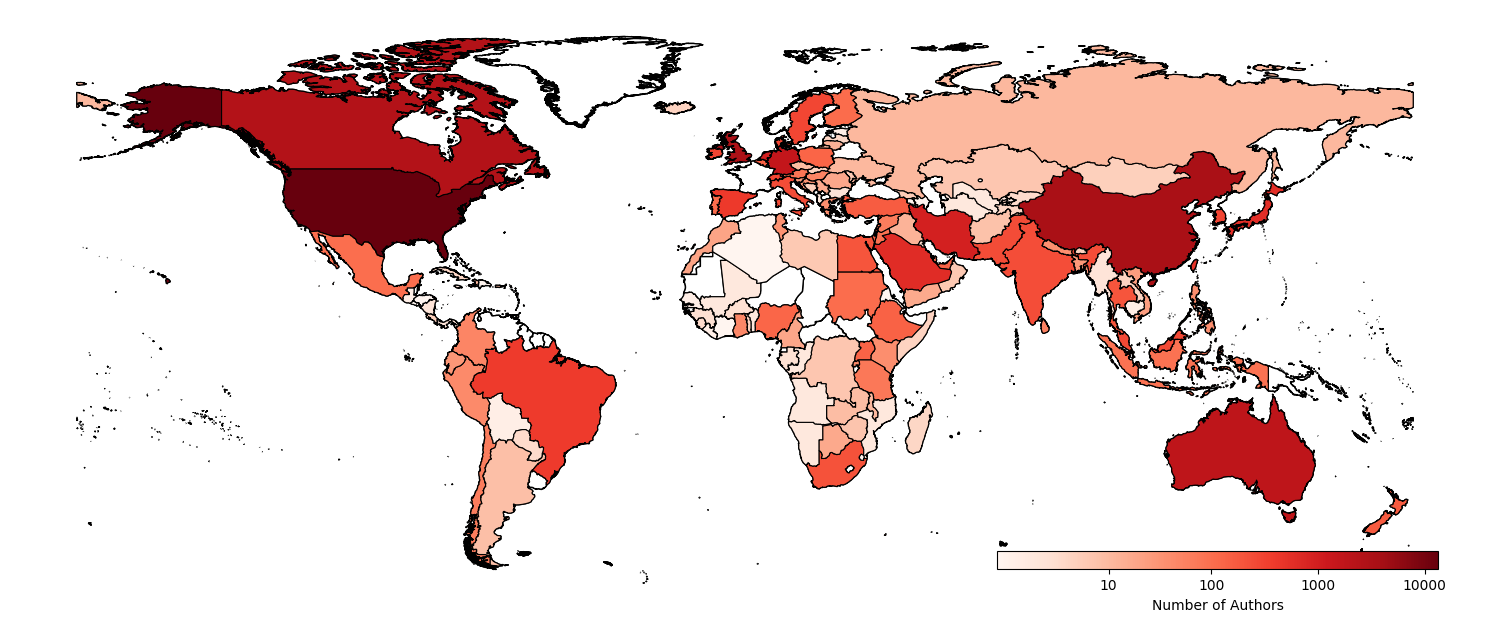

In [14]:
# Count authors per country
df = pd.read_csv('output/authors.csv')

country_counts = df['Country'].value_counts().reset_index()
country_counts.columns = ['ISO_A3', 'Author Count']

# Merge author data with map data
world_plt = world[world['ADMIN'] != 'Antarctica']  # Exclude Antarctica
merged = world_plt.merge(country_counts, on='ISO_A3', how='left')
merged['Author Count'] = merged['Author Count'].fillna(0)
merged['Log Author Count'] = np.log1p(merged['Author Count'])
display(merged)

# Separate subsets for plotting
has_authors = merged[merged['Author Count'] > 0]
no_authors = merged[merged['Author Count'] == 0] 

# Plot base map
fig, ax = plt.subplots(figsize=(15, 10))
world_plt.plot(ax=ax, edgecolor='black', color='white')  # Base world
no_authors.plot(ax=ax, color='white', edgecolor='black')  # Shade 0-author countries black

# Plot log-scaled author counts
plot = has_authors.plot(
    column='Log Author Count',
    cmap='Reds',
    linewidth=0.8,
    edgecolor='black',
    ax=ax
)

# Create horizontal inset colorbar
norm = plt.Normalize(vmin=merged['Log Author Count'].min(), vmax=merged['Log Author Count'].max())
sm = plt.cm.ScalarMappable(cmap='Reds', norm=norm)
sm._A = []

cax = inset_axes(ax, width="30%", height="3%", loc='lower right', borderpad=3)
cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')

# Custom ticks: 10, 100, 1000, 10000
custom_vals = [10, 100, 1000, 10000]
log_ticks = [np.log1p(v) for v in custom_vals]
cbar.set_ticks(log_ticks)
cbar.set_ticklabels([str(v) for v in custom_vals])
cbar.set_label("Number of Authors")

# Final tweaks
ax.axis('off')
plt.tight_layout()
plt.show()

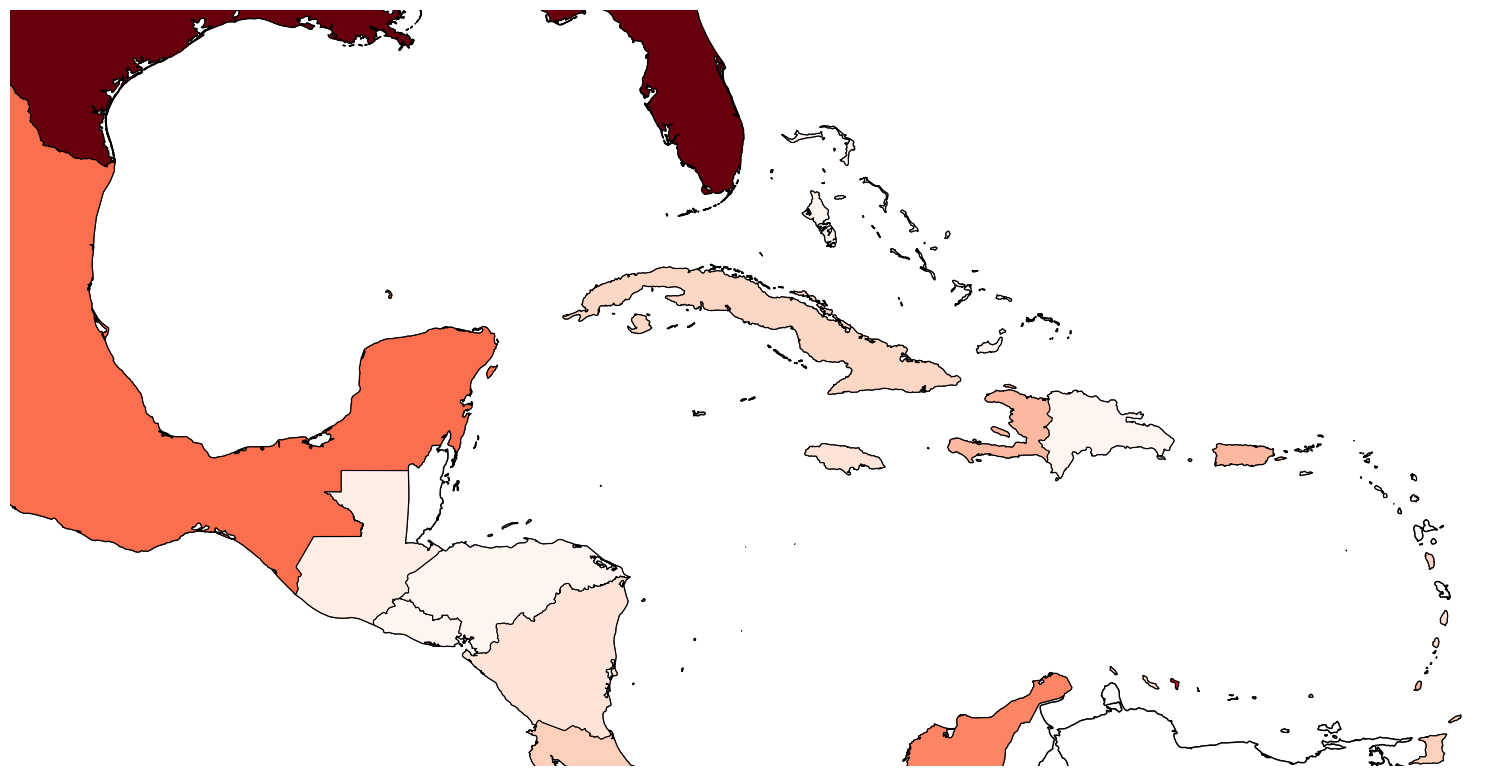

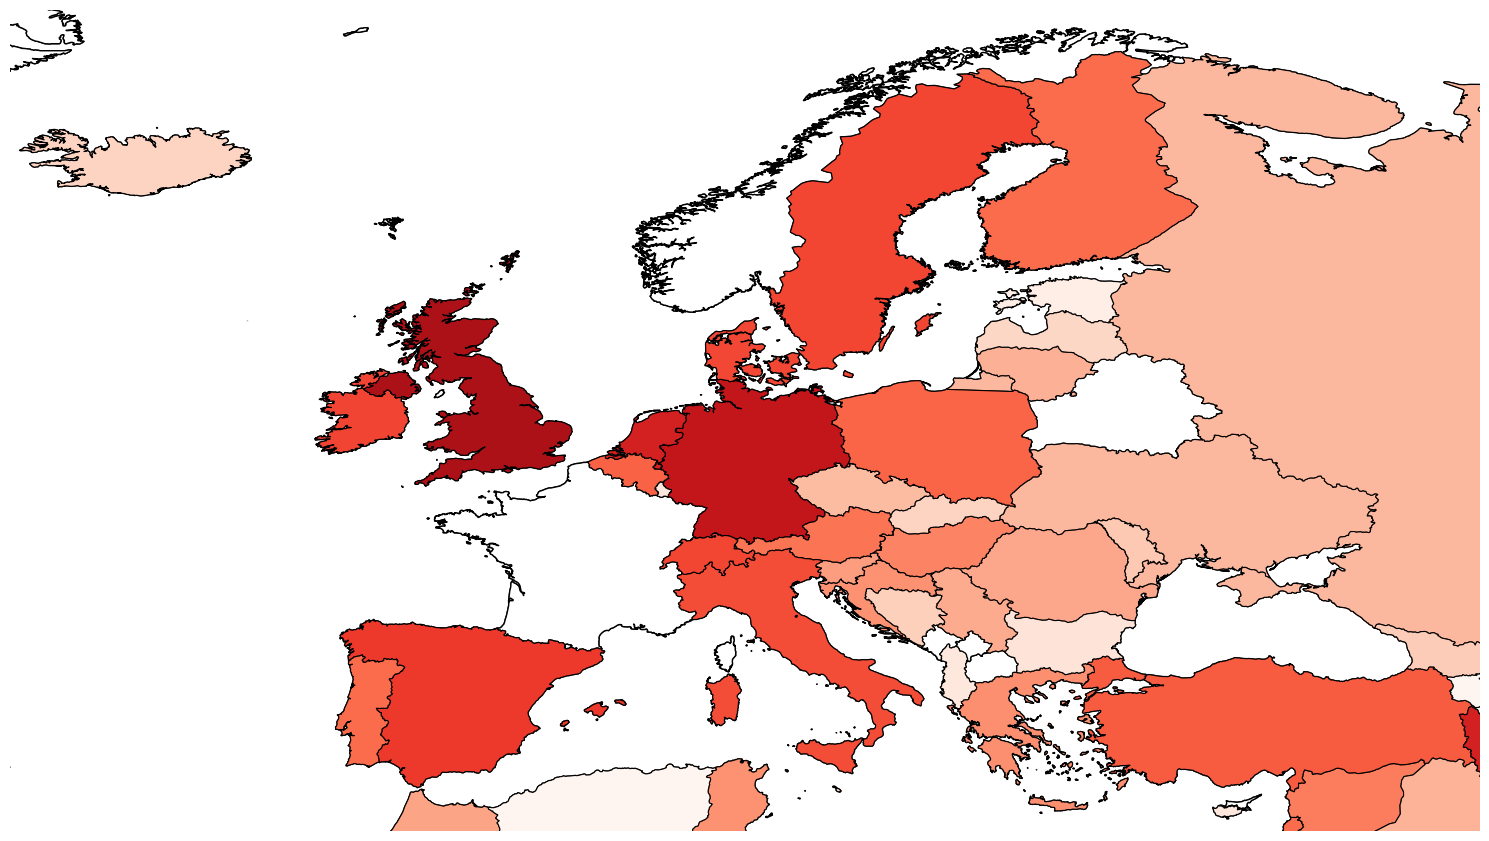

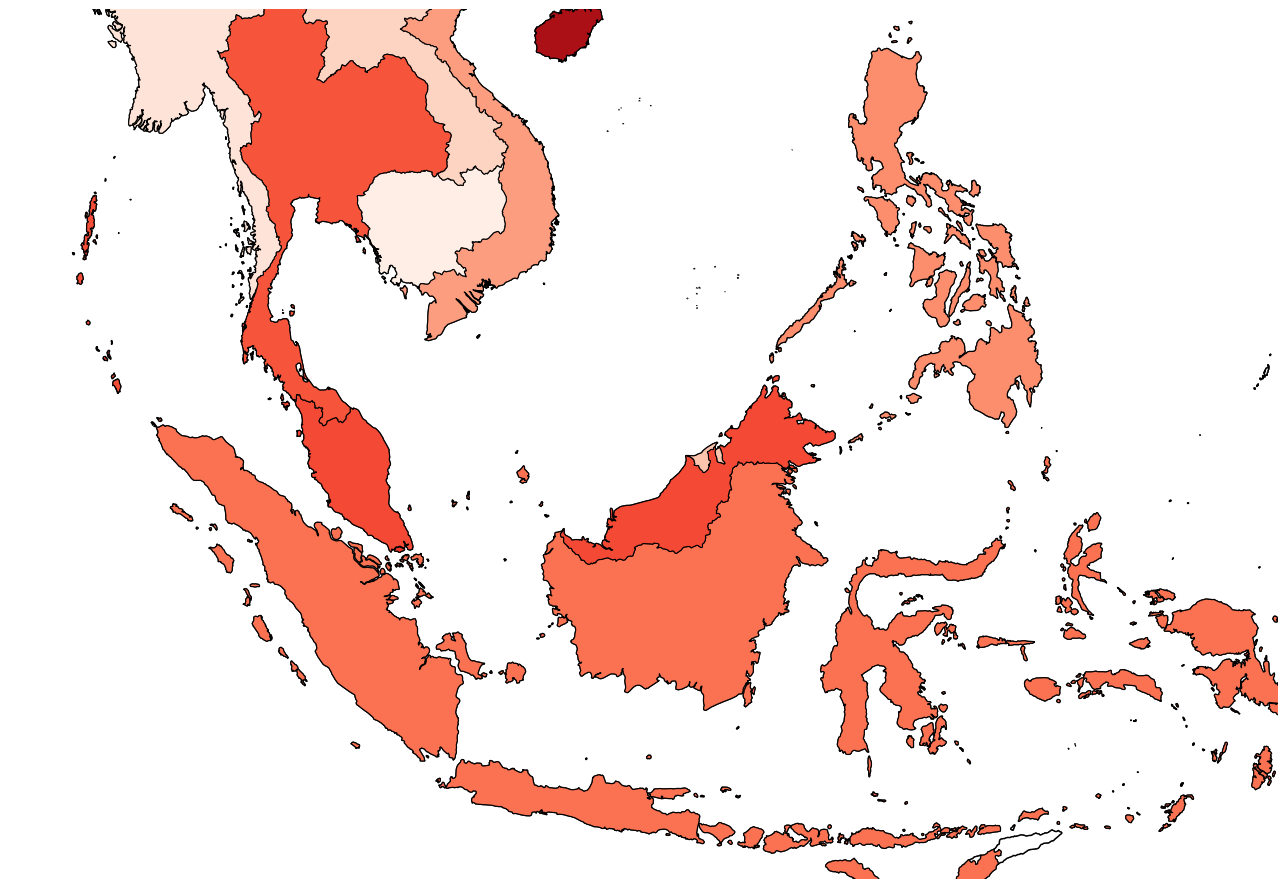

In [26]:
# Count authors per country
country_counts = df_grouped['Country'].value_counts().reset_index()
country_counts.columns = ['ISO_A3', 'Author Count']

# Merge author data with map data
world_plt = world[world['ADMIN'] != 'Antarctica']  # Exclude Antarctica
merged = world_plt.merge(country_counts, on='ISO_A3', how='left')
merged['Author Count'] = merged['Author Count'].fillna(0)
merged['Log Author Count'] = np.log1p(merged['Author Count'])

# Separate subsets for plotting
has_authors = merged[merged['Author Count'] > 0]
no_authors = merged[merged['Author Count'] == 0] 

# Define a reusable plotting function
def plot_region(title, xlim, ylim):
    fig, ax = plt.subplots(figsize=(15, 9))
    world_plt.plot(ax=ax, edgecolor='black', color='white')
    no_authors.plot(ax=ax, color='white', edgecolor='black')
    has_authors.plot(
        column='Log Author Count',
        cmap='Reds',
        linewidth=0.8,
        edgecolor='black',
        ax=ax
    )
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# 🌍 Plot Caribbean
plot_region("Caribbean Region", xlim=(-100, -60), ylim=(10, 30))

# 🇪🇺 Plot Europe
plot_region("Europe Region", xlim=(-25, 45), ylim=(34, 72))

# 🌏 Plot Southeast Asia
plot_region("Southeast Asia Region", xlim=(90, 135), ylim=(-10, 20))

In [ ]:
# Step 1: Prepare data
country_counts = df_grouped[df_grouped['Position'] == 'First Author']['Country'].value_counts().reset_index()
country_counts.columns = ['ISO_A3', 'Author Count']

# Merge author data with map data
world_plt = world[world['ADMIN'] != 'Antarctica']  # Exclude Antarctica
merged = world_plt.merge(country_counts, on='ISO_A3', how='left')
merged['Author Count'] = merged['Author Count'].fillna(0)
merged['Log Author Count'] = np.log1p(merged['Author Count'])

# Separate subsets for plotting
has_authors = merged[merged['Author Count'] > 0]
no_authors = merged[merged['Author Count'] == 0] 

# Plot base map
fig, ax = plt.subplots(figsize=(15, 10))
world_plt.plot(ax=ax, edgecolor='black', color='white')  # Base world
no_authors.plot(ax=ax, color='white', edgecolor='black')  # Shade 0-author countries black

# Plot log-scaled author counts
plot = has_authors.plot(
    column='Log Author Count',
    cmap='Reds',
    linewidth=0.8,
    edgecolor='black',
    ax=ax
)

# Create horizontal inset colorbar
norm = plt.Normalize(vmin=merged['Log Author Count'].min(), vmax=merged['Log Author Count'].max())
sm = plt.cm.ScalarMappable(cmap='Reds', norm=norm)
sm._A = []

cax = inset_axes(ax, width="30%", height="3%", loc='lower right', borderpad=3)
cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')

# Custom ticks: 10, 100, 1000, 10000
custom_vals = [10, 100, 1000, 2000]
log_ticks = [np.log1p(v) for v in custom_vals]
cbar.set_ticks(log_ticks)
cbar.set_ticklabels([str(v) for v in custom_vals])
cbar.set_label("Number of First Authors")

# Final tweaks
ax.set_title("Countries with First Author Contributions", fontsize=18)
ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
country_counts = df_grouped[df_grouped['Position'] == 'First Author']['Country'].value_counts().reset_index()
country_counts.columns = ['ISO_A3', 'Author Count']

# Merge author data with map data
world_plt = world[world['ADMIN'] != 'Antarctica']  # Exclude Antarctica
merged = world_plt.merge(country_counts, on='ISO_A3', how='left')
merged['Author Count'] = merged['Author Count'].fillna(0)
merged['Log Author Count'] = np.log1p(merged['Author Count'])

# Separate subsets for plotting
has_authors = merged[merged['Author Count'] > 0]
no_authors = merged[merged['Author Count'] == 0] 

# Define a reusable plotting function
def plot_region(title, xlim, ylim):
    fig, ax = plt.subplots(figsize=(15, 9))
    world_plt.plot(ax=ax, edgecolor='black', color='white')
    no_authors.plot(ax=ax, color='white', edgecolor='black')
    has_authors.plot(
        column='Log Author Count',
        cmap='Reds',
        linewidth=0.8,
        edgecolor='black',
        ax=ax
    )
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title(title, fontsize=14)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# 🌍 Plot Caribbean
plot_region("Caribbean Region", xlim=(-100, -60), ylim=(0, 30))

# 🇪🇺 Plot Europe
plot_region("Europe Region", xlim=(-25, 45), ylim=(34, 72))

# 🌏 Plot Southeast Asia
plot_region("Southeast Asia Region", xlim=(90, 135), ylim=(-12, 25))

In [71]:
# Load data
df_foranalyse = pd.read_csv('output/publications.csv')
country_gr = pd.read_csv('data/country_group.csv')

# Merge in income group
df = df_foranalyse.merge(country_gr[['Code', 'Income group']], how='left', left_on='Country', right_on='Code')

# Initialize mapping
doi_country_type = {}

# Group by DOI
grouped = df.groupby('DOI')

for doi, group in grouped:
    countries = group['Country'].dropna().unique()
    
    if len(countries) == 1:
        doi_country_type[doi] = 'Single'
    else:
        income_groups = group[['Country', 'Income group']].drop_duplicates()['Income group'].dropna().unique()
        if len(income_groups) == 1:
            doi_country_type[doi] = 'Multi-SameIncome'
        else:
            doi_country_type[doi] = 'Multi-DiffIncome'

# Add column to main dataframe
df['CountryType'] = df['DOI'].map(doi_country_type)

# Drop duplicates to avoid double-counting
df_unique = df[['DOI', 'Country', 'CountryType']].drop_duplicates()

# Count publications per country and type
counts = df_unique.groupby(['Country', 'CountryType'])['DOI'].nunique().reset_index()
counts = counts.pivot(index='Country', columns='CountryType', values='DOI').fillna(0).astype(int)
counts['Total'] = counts.sum(axis=1)

# First, make sure you have the full country-income mapping
country_income = country_gr[['Code', 'Income group']].drop_duplicates()
country_income.columns = ['Country', 'Income group']

# Merge income group into your summarized counts
counts_reset = counts.reset_index()
counts_with_income = counts_reset.merge(country_income, on='Country', how='left')

# Group by income group and sum collaboration types
grouped_by_income = counts_with_income.groupby('Income group')[['Single', 'Multi-SameIncome', 'Multi-DiffIncome', 'Total']].sum().astype(int)

display(grouped_by_income)


,Single,Multi-SameIncome,Multi-DiffIncome,Total
Income group,,,,
High income,7950,4807,1656,14413
Low income,76,0,183,259
Lower middle income,196,52,559,807
Upper middle income,1197,59,788,2044


In [46]:
# Use only multi-country DOIs
multi_df = df[df['DOI'].isin([doi for doi, ct in doi_country_type.items() if ct != 'Single'])]

# Group by DOI and get income groups per publication
doi_income_groups = multi_df.groupby('DOI')['Income group'].apply(lambda x: sorted(set(x.dropna())))

# Count combinations
from collections import Counter

def label_combo(income_list):
    return '+'.join(sorted(income_list))

combo_counter = Counter(doi_income_groups.apply(label_combo))
combo_counter.pop('', None)

# Convert to DataFrame
combo_df = pd.DataFrame(combo_counter.items(), columns=['Income Group Combination', 'Count']).sort_values(by='Count', ascending=False)

display(combo_df)

,Income Group Combination,Count
0,High income,2103
2,High income+Upper middle income,587
3,High income+Lower middle income,355
7,High income+Low income,107
8,High income+Lower middle income+Upper middle i...,49
1,Lower middle income+Upper middle income,41
4,Upper middle income,29
11,Lower middle income,27
6,High income+Low income+Lower middle income+Upp...,16
9,High income+Low income+Lower middle income,16


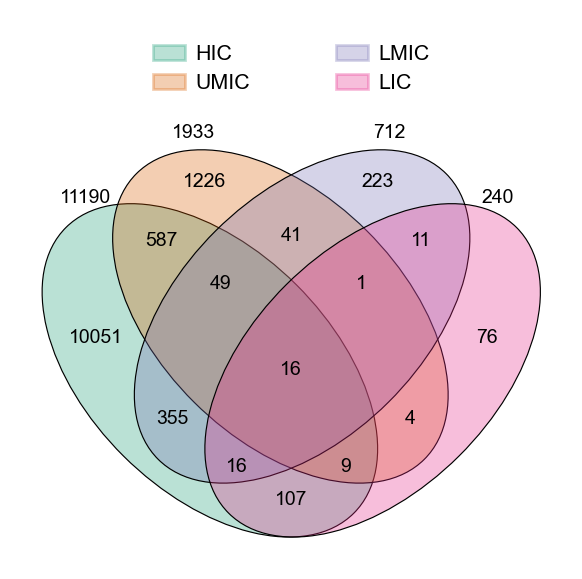

In [132]:
from venny4py.venny4py import venny4py as venn
import matplotlib.pyplot as plt

# Ensure all DOIs are strings and drop missing values
hic_dois = set(df[df['Income group'] == 'High income']['DOI'].dropna().astype(str))
umic_dois = set(df[df['Income group'] == 'Upper middle income']['DOI'].dropna().astype(str))
lmic_dois = set(df[df['Income group'] == 'Lower middle income']['DOI'].dropna().astype(str))
lic_dois  = set(df[df['Income group'] == 'Low income']['DOI'].dropna().astype(str))

# Plot 4-set Venn
colors = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a']
venn({'HIC': hic_dois, 'UMIC': umic_dois, 'LMIC': lmic_dois, 'LIC': lic_dois}, colors=colors)
plt.show()

In [30]:
df_foranalyse = pd.read_csv('output/publications.csv')

results = pd.DataFrame()

# Create export directory if not exists
export_dir = 'output/gephi_exports'
os.makedirs(export_dir, exist_ok=True)

for year in range(2015, 2025):
    result, G = network.network_coauthorship(df_foranalyse, 'Country', 'Year', year)
    
    # Append to results DataFrame
    results = pd.concat([results, result], ignore_index=True)
    
    # Export graph to GEXF format
    export_path = f'{export_dir}/coauthorship_{year}.gexf'
    nx.write_gexf(G, export_path)
    
display(results)


,Year,No of Publications,Single Author,Single Country,Nodes,Edges,Density,Average Clustering,Average Degree,Max Degree,Top Degree Centrality,Top Betweenness Centrality,Top Closeness Centrality,Top Eigenvector Centrality,No. of Communities
0,2015,883,95,626,71,196,0.078873,0.539983,5.521127,41,0.585714,0.424399,0.700000,0.352442,6
1,2016,963,91,741,65,199,0.095673,0.587675,6.123077,40,0.625000,0.441881,0.711111,0.405641,6
2,2017,942,69,660,70,256,0.106004,0.626284,7.314286,43,0.623188,0.410025,0.696970,0.369284,4
3,2018,967,69,702,75,279,0.100541,0.546950,7.440000,45,0.608108,0.401293,0.700541,0.308230,5
4,2019,1100,89,789,83,267,0.078460,0.537153,6.433735,50,0.609756,0.372782,0.690697,0.344823,7
5,2020,1376,83,900,84,515,0.147734,0.656263,12.261905,53,0.638554,0.327517,0.728070,0.260730,4
6,2021,1423,67,991,100,414,0.083636,0.574245,8.280000,65,0.656566,0.403940,0.733333,0.343272,7
7,2022,1541,52,1143,95,401,0.089810,0.610420,8.442105,63,0.670213,0.360032,0.752000,0.355549,3
8,2023,1547,55,1126,96,386,0.084649,0.487230,8.041667,54,0.568421,0.325336,0.693431,0.334847,6
9,2024,2445,77,1741,123,969,0.129148,0.626898,15.756098,79,0.647541,0.177978,0.734940,0.244415,4


In [39]:
# Define color map for income categories
income_colors = {
    'High income': '#1b9e77',
    'Upper middle income': '#d95f02',
    'Lower middle income': '#7570b3',
    'Low income': '#e7298a',
    'Other': '#ffffff'
}

# Optional: keep top N (e.g., top 20 in 2024)
top_n = 15

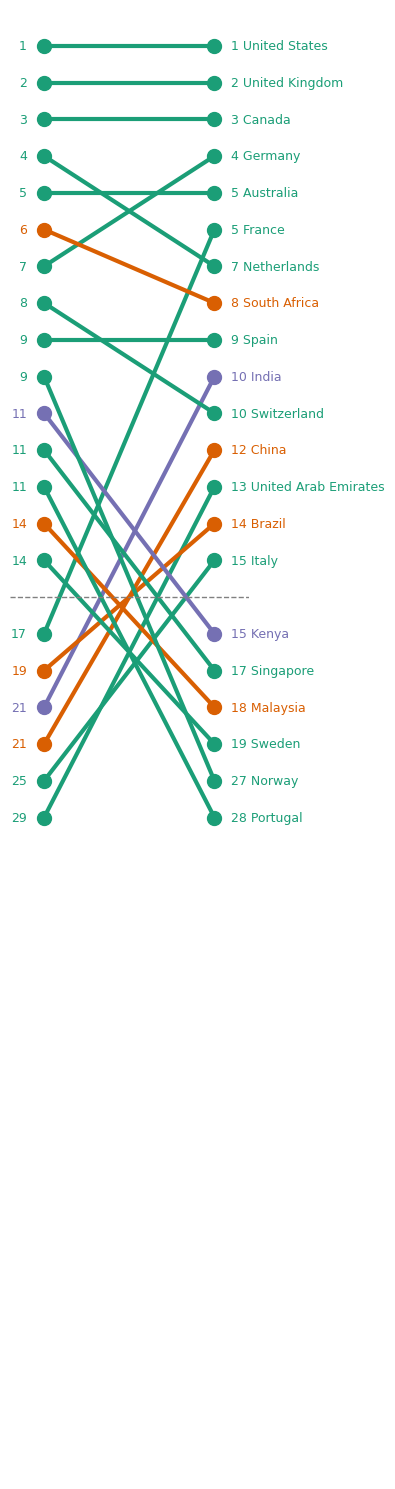

In [86]:
df_foranalyse = pd.read_csv('output/publications.csv')

G_2020 = network.network_coauthorship(df_foranalyse, 'Country', 'Year', range(2015, 2020))
G_2024 = network.network_coauthorship(df_foranalyse, 'Country')

deg_2015 = nx.degree_centrality(G_2020)
deg_2024 = nx.degree_centrality(G_2024)

df_2015 = pd.DataFrame(deg_2015.items(), columns=['Country', 'Score_2015'])
df_2024 = pd.DataFrame(deg_2024.items(), columns=['Country', 'Score_2024'])
df_merged = pd.merge(df_2015, df_2024, on='Country', how='outer').fillna(0)

# Compute ranks (lower rank = more central)
df_merged['Rank_2015_label'] = df_merged['Score_2015'].rank(ascending=False, method='min').astype(int)
df_merged['Rank_2015'] = df_merged['Score_2015'].rank(ascending=False, method='min').astype(int)
df_merged['Rank_2024_label'] = df_merged['Score_2024'].rank(ascending=False, method='min').astype(int)
df_merged['Rank_2024'] = df_merged['Score_2024'].rank(ascending=False, method='min').astype(int)

# Get top 20 by each year
top_2015 = df_merged.nsmallest(top_n, 'Rank_2015')['Country']
top_2024 = df_merged.nsmallest(top_n, 'Rank_2024')['Country']
top_countries = pd.Series(list(set(top_2015).union(set(top_2024))))

# Filter the main DataFrame
df_bump = df_merged[df_merged['Country'].isin(top_countries)].reset_index(drop=True)
df_bump = df_bump.merge(country_gr[['Code', 'Economy', 'Income group']], left_on='Country', right_on='Code')
df_bump = df_bump.sort_values(by='Rank_2024').reset_index(drop=True)
df_bump['Rank_2015_display'] = df_bump['Rank_2015'].rank(method='first').astype(int)
df_bump['Rank_2024_display'] = df_bump['Rank_2024'].rank(method='first').astype(int)
df_bump.loc[df_bump['Rank_2015_display'] > 15, 'Rank_2015_display'] += 1
df_bump.loc[df_bump['Rank_2024_display'] > 15, 'Rank_2024_display'] += 1

# Start plot
fig, ax = plt.subplots(figsize=(4, 15))

# Plot lines with width = average centrality, colored by income
for _, row in df_bump.iterrows():
    x = [0, 1]
    y = [row['Rank_2015_display'], row['Rank_2024_display']]
    color = income_colors.get(row['Income group'], income_colors['Other'])

    # Smooth curve
    ax.plot(x, y, color=color, linewidth=3, alpha=1, marker='o', markersize=10)
    
    ax.text(-0.10, y[0], row['Rank_2015_label'], ha='right', va='center', fontsize=9, color=color)
    ax.text(1.10, y[1], f'{row['Rank_2024_label']} {row['Economy']}', ha='left', va='center', fontsize=9, color=color)

# Axis tweaks
ax.axhline(y=16, color='gray', linestyle='--', linewidth=1)
ax.set_xlim(-0.2, 1.2)
ax.set_ylim(40, 0)
ax.set_xticks([0, 1])
ax.set_xticklabels(['2015', '2024'], fontsize=12)
ax.axis('off')

# Legend
legend_elements = [Line2D([0], [0], color=color, lw=4, label=label) 
                   for label, color in income_colors.items()]
# ax.legend(handles=legend_elements, title='Income Group', loc='upper right')

plt.tight_layout()
plt.show()

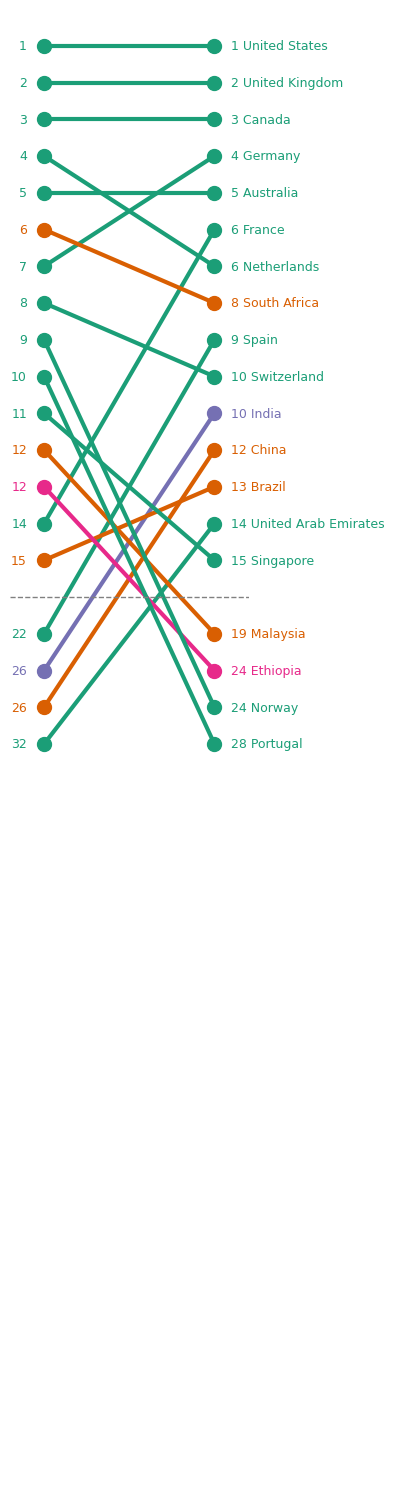

In [85]:
df_foranalyse = pd.read_csv('output/publications.csv')

G_2020 = network.network_coauthorship(df_foranalyse, 'Country', 'Year', range(2015, 2020))
G_2024 = network.network_coauthorship(df_foranalyse, 'Country')

cls_2015 = nx.closeness_centrality(G_2020)
cls_2024 = nx.closeness_centrality(G_2024)

df_2015 = pd.DataFrame(cls_2015.items(), columns=['Country', 'Score_2015'])
df_2024 = pd.DataFrame(cls_2024.items(), columns=['Country', 'Score_2024'])
df_merged = pd.merge(df_2015, df_2024, on='Country', how='outer').fillna(0)

# Compute ranks (lower rank = more central)
df_merged['Rank_2015_label'] = df_merged['Score_2015'].rank(ascending=False, method='min').astype(int)
df_merged['Rank_2015'] = df_merged['Score_2015'].rank(ascending=False, method='min').astype(int)
df_merged['Rank_2024_label'] = df_merged['Score_2024'].rank(ascending=False, method='min').astype(int)
df_merged['Rank_2024'] = df_merged['Score_2024'].rank(ascending=False, method='min').astype(int)

# Get top 20 by each year
top_2015 = df_merged.nsmallest(top_n, 'Rank_2015')['Country']
top_2024 = df_merged.nsmallest(top_n, 'Rank_2024')['Country']
top_countries = pd.Series(list(set(top_2015).union(set(top_2024))))

# Filter the main DataFrame
df_bump = df_merged[df_merged['Country'].isin(top_countries)].reset_index(drop=True)
df_bump = df_bump.merge(country_gr[['Code', 'Economy', 'Income group']], left_on='Country', right_on='Code')
df_bump = df_bump.sort_values(by='Rank_2024').reset_index(drop=True)
df_bump['Rank_2015_display'] = df_bump['Rank_2015'].rank(method='first').astype(int)
df_bump['Rank_2024_display'] = df_bump['Rank_2024'].rank(method='first').astype(int)
df_bump.loc[df_bump['Rank_2015_display'] > 15, 'Rank_2015_display'] += 1
df_bump.loc[df_bump['Rank_2024_display'] > 15, 'Rank_2024_display'] += 1

# Start plot
fig, ax = plt.subplots(figsize=(4, 15))

# Plot lines with width = average centrality, colored by income
for _, row in df_bump.iterrows():
    x = [0, 1]
    y = [row['Rank_2015_display'], row['Rank_2024_display']]
    color = income_colors.get(row['Income group'], income_colors['Other'])

    # Smooth curve
    ax.plot(x, y, color=color, linewidth=3, alpha=1, marker='o', markersize=10)
    
    ax.text(-0.10, y[0], row['Rank_2015_label'], ha='right', va='center', fontsize=9, color=color)
    ax.text(1.10, y[1], f'{row['Rank_2024_label']} {row['Economy']}', ha='left', va='center', fontsize=9, color=color)

# Axis tweaks
ax.axhline(y=16, color='gray', linestyle='--', linewidth=1)
ax.set_xlim(-0.2, 1.2)
ax.set_ylim(40, 0)
ax.set_xticks([0, 1])
ax.set_xticklabels(['2015', '2024'], fontsize=12)
ax.axis('off')

# Legend
legend_elements = [Line2D([0], [0], color=color, lw=4, label=label) 
                   for label, color in income_colors.items()]
# ax.legend(handles=legend_elements, title='Income Group', loc='upper right')

plt.tight_layout()
plt.show()

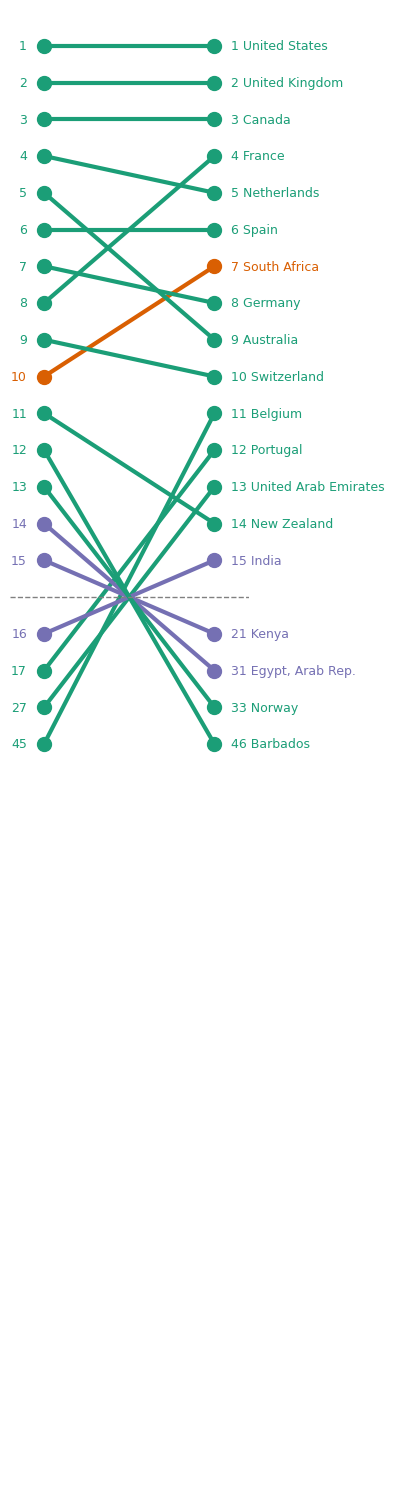

In [84]:
df_foranalyse = pd.read_csv('output/publications.csv')

G_2020 = network.network_coauthorship(df_foranalyse, 'Country', 'Year', range(2015, 2020))
G_2024 = network.network_coauthorship(df_foranalyse, 'Country')

btw_2015 = nx.betweenness_centrality(G_2020)
btw_2024 = nx.betweenness_centrality(G_2024)

df_2015 = pd.DataFrame(btw_2015.items(), columns=['Country', 'Score_2015'])
df_2024 = pd.DataFrame(btw_2024.items(), columns=['Country', 'Score_2024'])
df_merged = pd.merge(df_2015, df_2024, on='Country', how='outer').fillna(0)

# Compute ranks (lower rank = more central)
df_merged['Rank_2015_label'] = df_merged['Score_2015'].rank(ascending=False, method='min').astype(int)
df_merged['Rank_2015'] = df_merged['Score_2015'].rank(ascending=False, method='min').astype(int)
df_merged['Rank_2024_label'] = df_merged['Score_2024'].rank(ascending=False, method='min').astype(int)
df_merged['Rank_2024'] = df_merged['Score_2024'].rank(ascending=False, method='min').astype(int)

# Get top 20 by each year
top_2015 = df_merged.nsmallest(top_n, 'Rank_2015')['Country']
top_2024 = df_merged.nsmallest(top_n, 'Rank_2024')['Country']
top_countries = pd.Series(list(set(top_2015).union(set(top_2024))))

# Filter the main DataFrame
df_bump = df_merged[df_merged['Country'].isin(top_countries)].reset_index(drop=True)
df_bump = df_bump.merge(country_gr[['Code', 'Economy', 'Income group']], left_on='Country', right_on='Code')
df_bump = df_bump.sort_values(by='Rank_2024').reset_index(drop=True)
df_bump['Rank_2015_display'] = df_bump['Rank_2015'].rank(method='first').astype(int)
df_bump['Rank_2024_display'] = df_bump['Rank_2024'].rank(method='first').astype(int)
df_bump.loc[df_bump['Rank_2015_display'] > 15, 'Rank_2015_display'] += 1
df_bump.loc[df_bump['Rank_2024_display'] > 15, 'Rank_2024_display'] += 1

# Start plot
fig, ax = plt.subplots(figsize=(4, 15))

# Plot lines with width = average centrality, colored by income
for _, row in df_bump.iterrows():
    x = [0, 1]
    y = [row['Rank_2015_display'], row['Rank_2024_display']]
    color = income_colors.get(row['Income group'], income_colors['Other'])

    # Smooth curve
    ax.plot(x, y, color=color, linewidth=3, alpha=1, marker='o', markersize=10)
    
    ax.text(-0.10, y[0], row['Rank_2015_label'], ha='right', va='center', fontsize=9, color=color)
    ax.text(1.10, y[1], f'{row['Rank_2024_label']} {row['Economy']}', ha='left', va='center', fontsize=9, color=color)

# Axis tweaks
ax.axhline(y=16, color='gray', linestyle='--', linewidth=1)
ax.set_xlim(-0.2, 1.2)
ax.set_ylim(40, 0)
ax.set_xticks([0, 1])
ax.set_xticklabels(['2015', '2024'], fontsize=12)
ax.axis('off')

# Legend
legend_elements = [Line2D([0], [0], color=color, lw=4, label=label) 
                   for label, color in income_colors.items()]
# ax.legend(handles=legend_elements, title='Income Group', loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
from collections import defaultdict

def partition_to_dict(partition):
    return {node: i for i, comm in enumerate(partition) for node in comm}

def participation_coefficient(G, node_community):
    
    participation_coefficients = {}
    for node in G.nodes():
        k_i = G.degree(node, weight='weight')
        if k_i == 0:
            participation = 0
        else:
            comm_weights = defaultdict(float)
            for neighbor in G.neighbors(node):
                edge_weight = G[node][neighbor].get('weight', 1)
                comm = node_community.get(neighbor)
                comm_weights[comm] += edge_weight
            participation = 1 - sum((w / k_i) ** 2 for w in comm_weights.values())
        G.nodes[node]['participation_coefficient'] = participation
        participation_coefficients[node] = participation
            
    return participation_coefficients

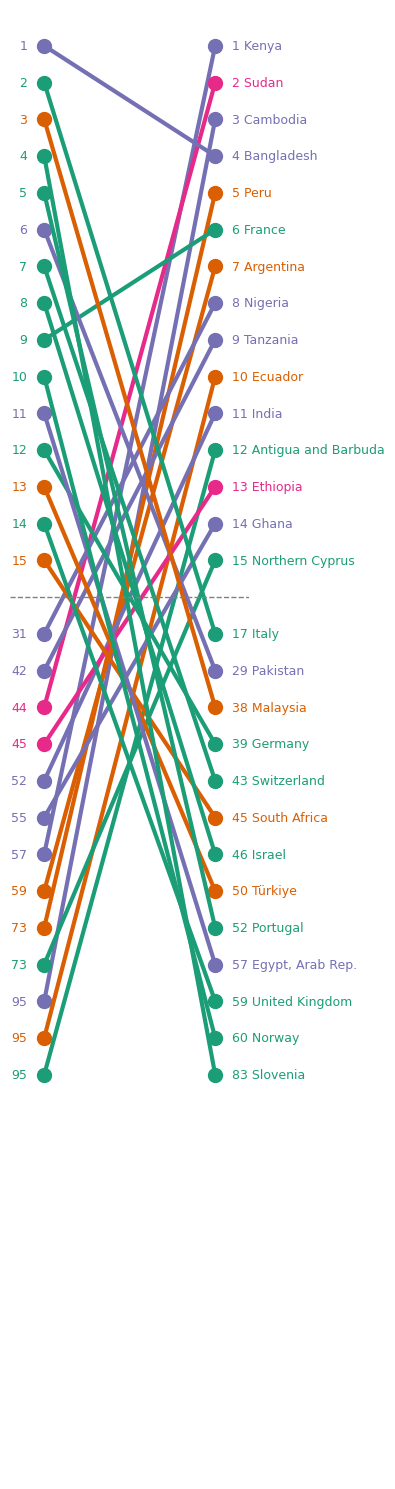

In [83]:
df_foranalyse = pd.read_csv('output/publications.csv')

G_2020 = network.network_coauthorship(df_foranalyse, 'Country', 'Year', range(2015, 2020))
G_2024 = network.network_coauthorship(df_foranalyse, 'Country')

import community as community_louvain
partition_2015 = community_louvain.best_partition(G_2020, random_state=42)
partition_2024 = community_louvain.best_partition(G_2024, random_state=42)

# Compute participation coefficient
pc_2015 = participation_coefficient(G_2020, partition_2015)
pc_2024 = participation_coefficient(G_2024, partition_2024)

# Create DataFrames
df_pc_2015 = pd.DataFrame(pc_2015.items(), columns=['Country', 'PC_2015'])
df_pc_2024 = pd.DataFrame(pc_2024.items(), columns=['Country', 'PC_2024'])

df_pc = pd.merge(df_pc_2015, df_pc_2024, on='Country', how='outer').fillna(0)
df_pc['Rank_2015_label'] = df_pc['PC_2015'].rank(ascending=False, method='min').astype(int)
df_pc['Rank_2024_label'] = df_pc['PC_2024'].rank(ascending=False, method='min').astype(int)
df_pc['Rank_2015'] = df_pc['PC_2015'].rank(ascending=False, method='min').astype(int)
df_pc['Rank_2024'] = df_pc['PC_2024'].rank(ascending=False, method='min').astype(int)

# Top countries by either year
top_2015_pc = df_pc.nsmallest(top_n, 'Rank_2015')['Country']
top_2024_pc = df_pc.nsmallest(top_n, 'Rank_2024')['Country']
top_countries_pc = pd.Series(list(set(top_2015_pc).union(set(top_2024_pc))))

# Filter and merge metadata
df_bump_pc = df_pc[df_pc['Country'].isin(top_countries_pc)].reset_index(drop=True)
df_bump_pc = df_bump_pc.merge(country_gr[['Code', 'Economy', 'Income group']], left_on='Country', right_on='Code')
df_bump_pc = df_bump_pc.sort_values(by='Rank_2024').reset_index(drop=True)
df_bump_pc['Rank_2015_display'] = df_bump_pc['Rank_2015'].rank(method='first').astype(int)
df_bump_pc['Rank_2024_display'] = df_bump_pc['Rank_2024'].rank(method='first').astype(int)
df_bump_pc.loc[df_bump_pc['Rank_2015_display'] > 15, 'Rank_2015_display'] += 1
df_bump_pc.loc[df_bump_pc['Rank_2024_display'] > 15, 'Rank_2024_display'] += 1

# Start plot
fig, ax = plt.subplots(figsize=(4, 15))

# Plot lines with width = average centrality, colored by income
for _, row in df_bump_pc.iterrows():
    x = [0, 1]
    y = [row['Rank_2015_display'], row['Rank_2024_display']]
    color = income_colors.get(row['Income group'], income_colors['Other'])

    # Smooth curve
    ax.plot(x, y, color=color, linewidth=3, alpha=1, marker='o', markersize=10)
    
    ax.text(-0.10, y[0], row['Rank_2015_label'], ha='right', va='center', fontsize=9, color=color)
    ax.text(1.10, y[1], f'{row['Rank_2024_label']} {row['Economy']}', ha='left', va='center', fontsize=9, color=color)

# Axis tweaks
ax.axhline(y=16, color='gray', linestyle='--', linewidth=1)
ax.set_xlim(-0.2, 1.2)
ax.set_ylim(40, 0)
ax.set_xticks([0, 1])
ax.set_xticklabels(['2015', '2024'], fontsize=12)
ax.axis('off')

# Legend
legend_elements = [Line2D([0], [0], color=color, lw=4, label=label) 
                   for label, color in income_colors.items()]
# ax.legend(handles=legend_elements, title='Income Group', loc='upper right')

plt.tight_layout()
plt.show()

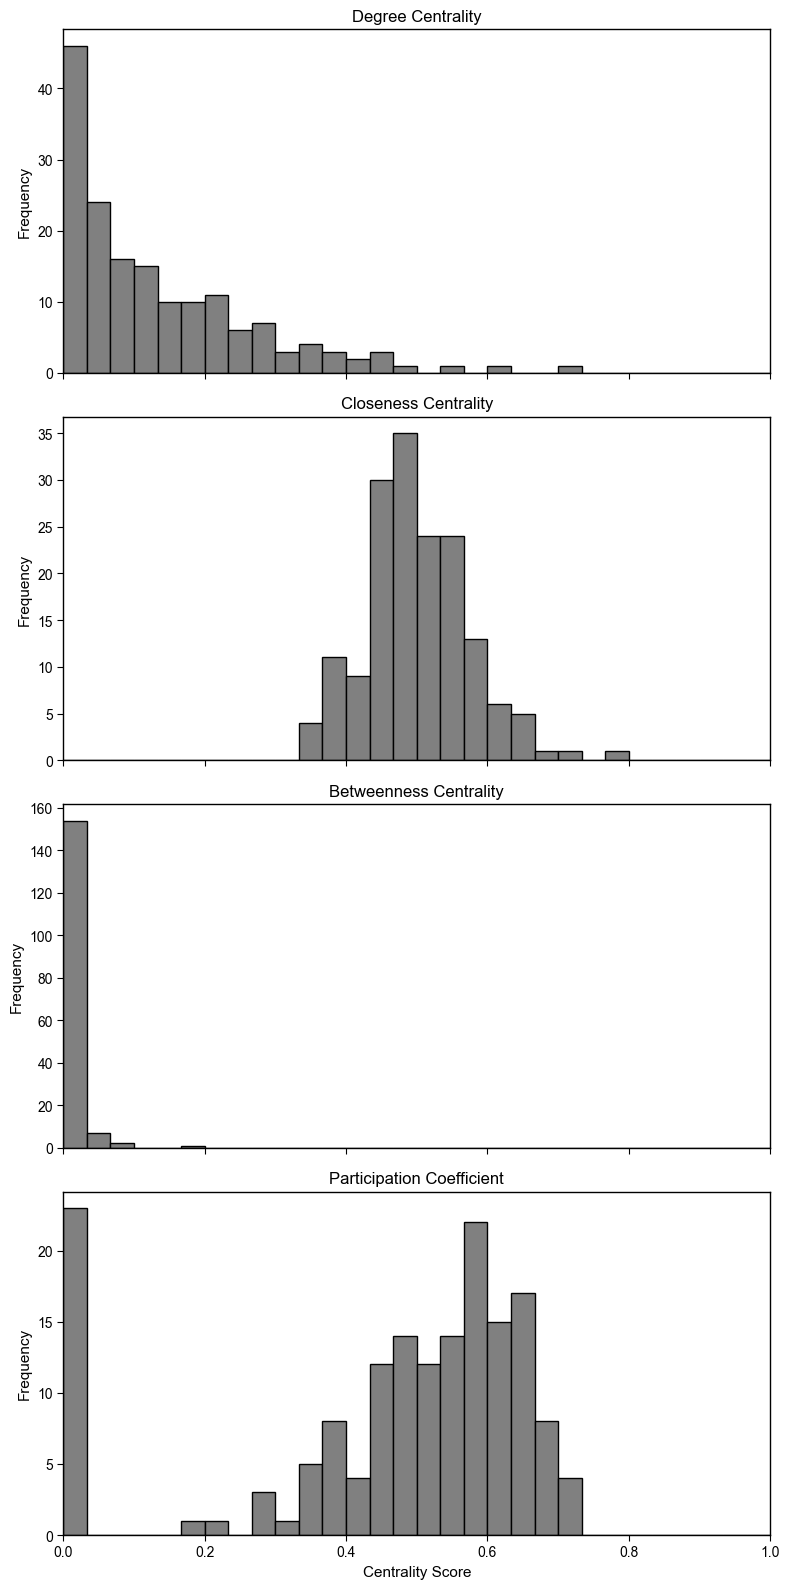

In [91]:
df_foranalyse = pd.read_csv('output/publications.csv')

G = network.network_coauthorship(df_foranalyse, 'Country')

deg = nx.degree_centrality(G)
cls = nx.closeness_centrality(G)
btw = nx.betweenness_centrality(G)
partition = community_louvain.best_partition(G, random_state=42)
pc = participation_coefficient(G, partition)

# Convert to lists
deg_values = list(deg.values())
cls_values = list(cls.values())
btw_values = list(btw.values())
part_values = list(pc.values())
    
# Plotting
fig, axs = plt.subplots(4, 1, figsize=(8, 16), sharex=False)
bins = np.linspace(0, 1, 31)  # 30 equal-width bins between 0 and 1

# Degree centrality
axs[0].hist(deg_values, bins=bins, color='grey', edgecolor='black')
axs[0].set_title('Degree Centrality', fontsize=12)
axs[0].set_ylabel('Frequency')
axs[0].set_xlim(0,1)
axs[0].tick_params(labelbottom=False)  # Hide x-axis labels

# Closeness centrality
axs[1].hist(cls_values, bins=bins, color='grey', edgecolor='black')
axs[1].set_title('Closeness Centrality', fontsize=12)
axs[1].set_ylabel('Frequency')
axs[1].set_xlim(0,1)
axs[1].tick_params(labelbottom=False)  # Hide x-axis labels

# Betweenness centrality
axs[2].hist(btw_values, bins=bins, color='grey', edgecolor='black')
axs[2].set_title('Betweenness Centrality', fontsize=12)
axs[2].set_ylabel('Frequency')
axs[2].set_xlim(0,1)
axs[2].tick_params(labelbottom=False)  # Hide x-axis labels

# Participation coefficient
axs[3].hist(part_values, bins=bins, color='grey', edgecolor='black')
axs[3].set_title('Participation Coefficient', fontsize=12)
axs[3].set_ylabel('Frequency')
axs[3].set_xlabel('Centrality Score')
axs[3].set_xlim(0,1)

# Tight layout
plt.tight_layout()
plt.show()

/var/folders/bf/rp_bmxh57x748ppg9b4stxy80000gn/T/ipykernel_76620/3139310318.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mod_class: cm.get_cmap('tab20')(i % 20)


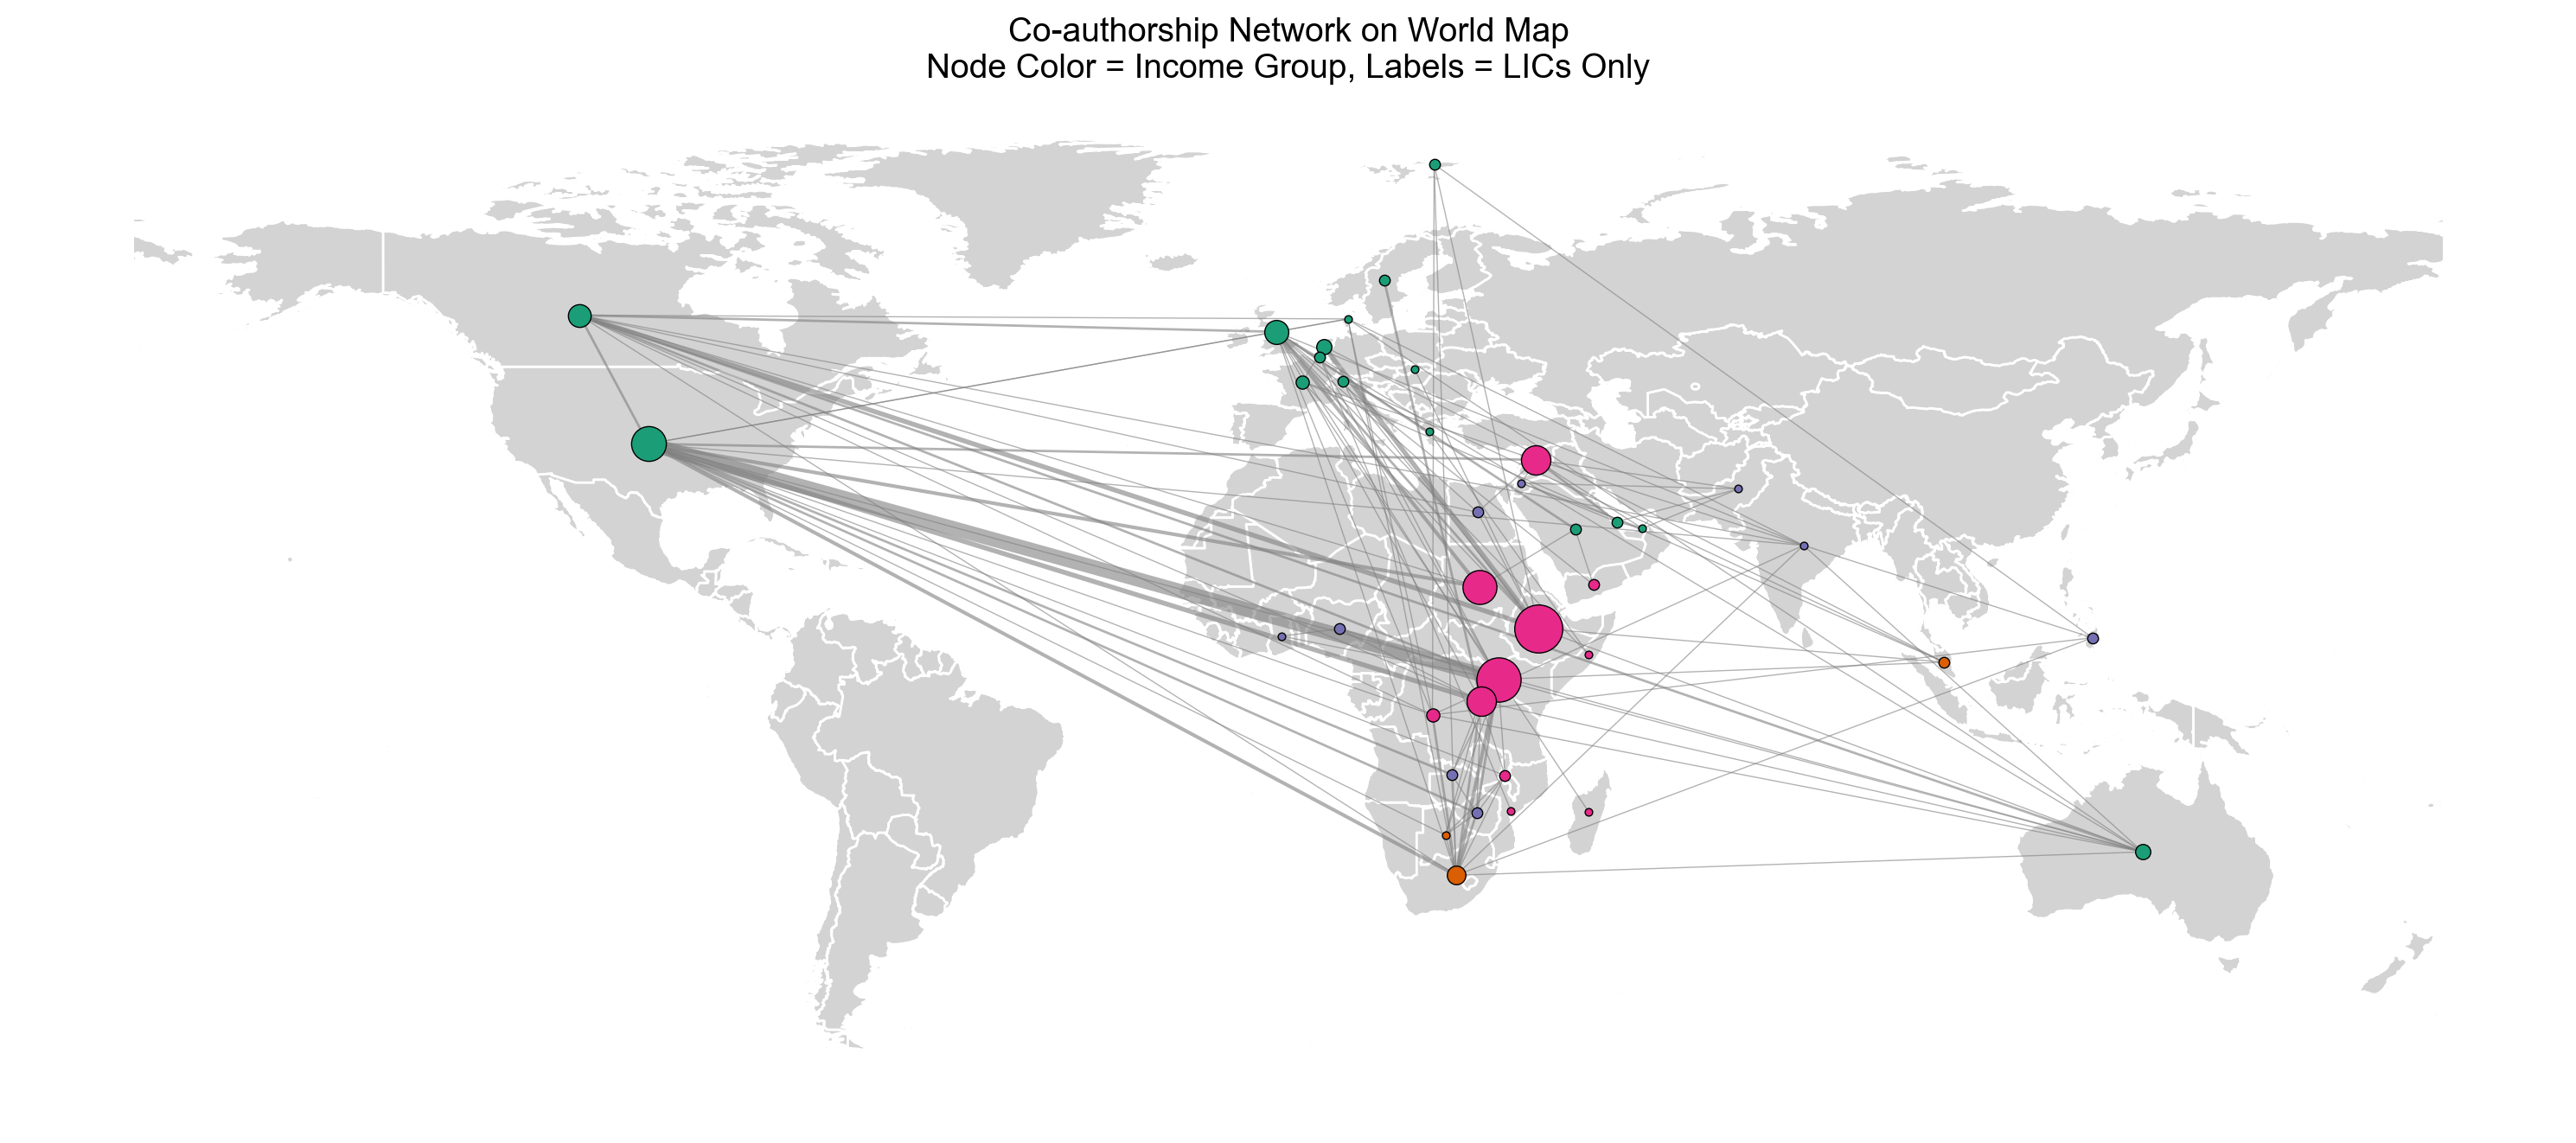

In [194]:
df_foranalyse = pd.read_csv('output/publications.csv')
country_gr = pd.read_csv('data/country_group.csv')
df_foranalyse = df_foranalyse.merge(country_gr[['Code', 'Income group']], how='left', left_on='Country', right_on='Code')
lic_set = set(df_foranalyse[(df_foranalyse['Income group'] == 'Low income') & (df_foranalyse['Position'] == 'First Author')]['DOI'])
df_lic = df_foranalyse[df_foranalyse['DOI'].isin(lic_set)]

_, G = network.network_coauthorship(df_lic, 'Country')
country_income = df_lic[['Country', 'Income group']].drop_duplicates().set_index('Country')['Income group'].to_dict()
for node in G.nodes:
    G.nodes[node]['Income group'] = country_income.get(node, 'Other')  # default to 'Other' if missing

# Get positions of nodes using country geometries
node_countries = list(G.nodes)
world_nodes = world[world['ADM0_A3'].isin(node_countries)].copy()
world_nodes['coords'] = world_nodes['geometry'].representative_point()
positions = {row['ADM0_A3']: (row['coords'].x, row['coords'].y) for idx, row in world_nodes.iterrows()}

mod_classes = set(nx.get_node_attributes(G, 'modularity_class').values())
mod_class_to_color = {
    mod_class: cm.get_cmap('tab20')(i % 20)
    for i, mod_class in enumerate(sorted(mod_classes))
}

# === WORLD MAP with INCOME GROUP COLORING ===
fig, ax = plt.subplots(figsize=(15, 10))
world.plot(ax=ax, color='lightgray', edgecolor='white')

# Plot edges
for u, v, data in G.edges(data=True):
    if u in positions and v in positions:
        x0, y0 = positions[u]
        x1, y1 = positions[v]
        ax.plot([x0, x1], [y0, y1],
                color='gray',
                linewidth=data.get('weight', 1) * 0.5,
                alpha=0.6,
                zorder=1)

# Plot nodes: color by income group
for node in G.nodes:
    if node in positions:
        x, y = positions[node]
        size = G.nodes[node].get('size', 1) * 10
        income = G.nodes[node].get('Income group', 'Other')
        color = income_colors.get(income, 'gray')
        ax.scatter(x, y,
                   s=size,
                   color=color,
                   edgecolor='black',
                   linewidth=0.5,
                   zorder=2)

plt.title('Co-authorship Network on World Map\nNode Color = Income Group, Labels = LICs Only', fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()


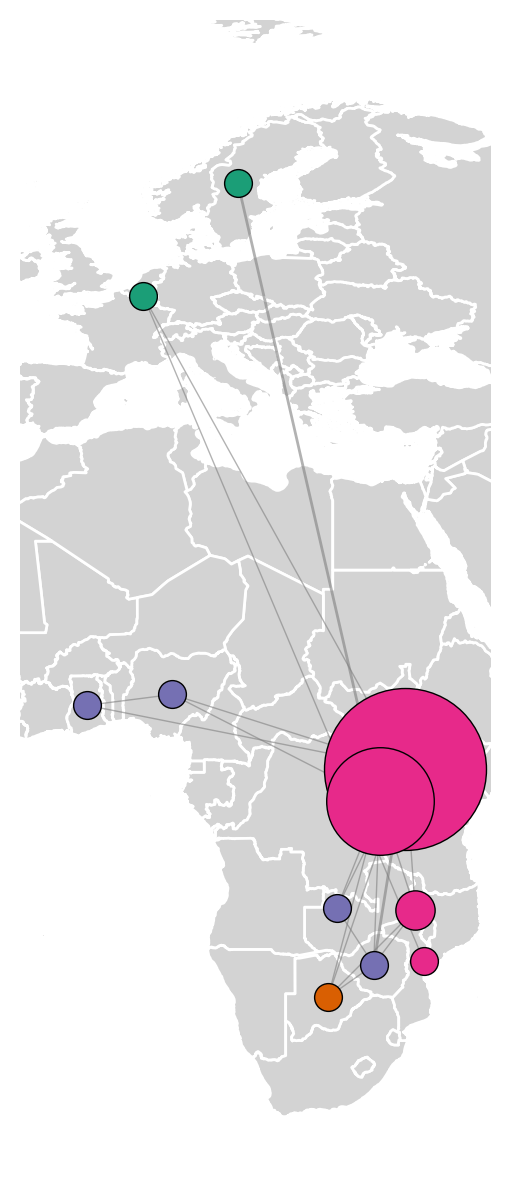

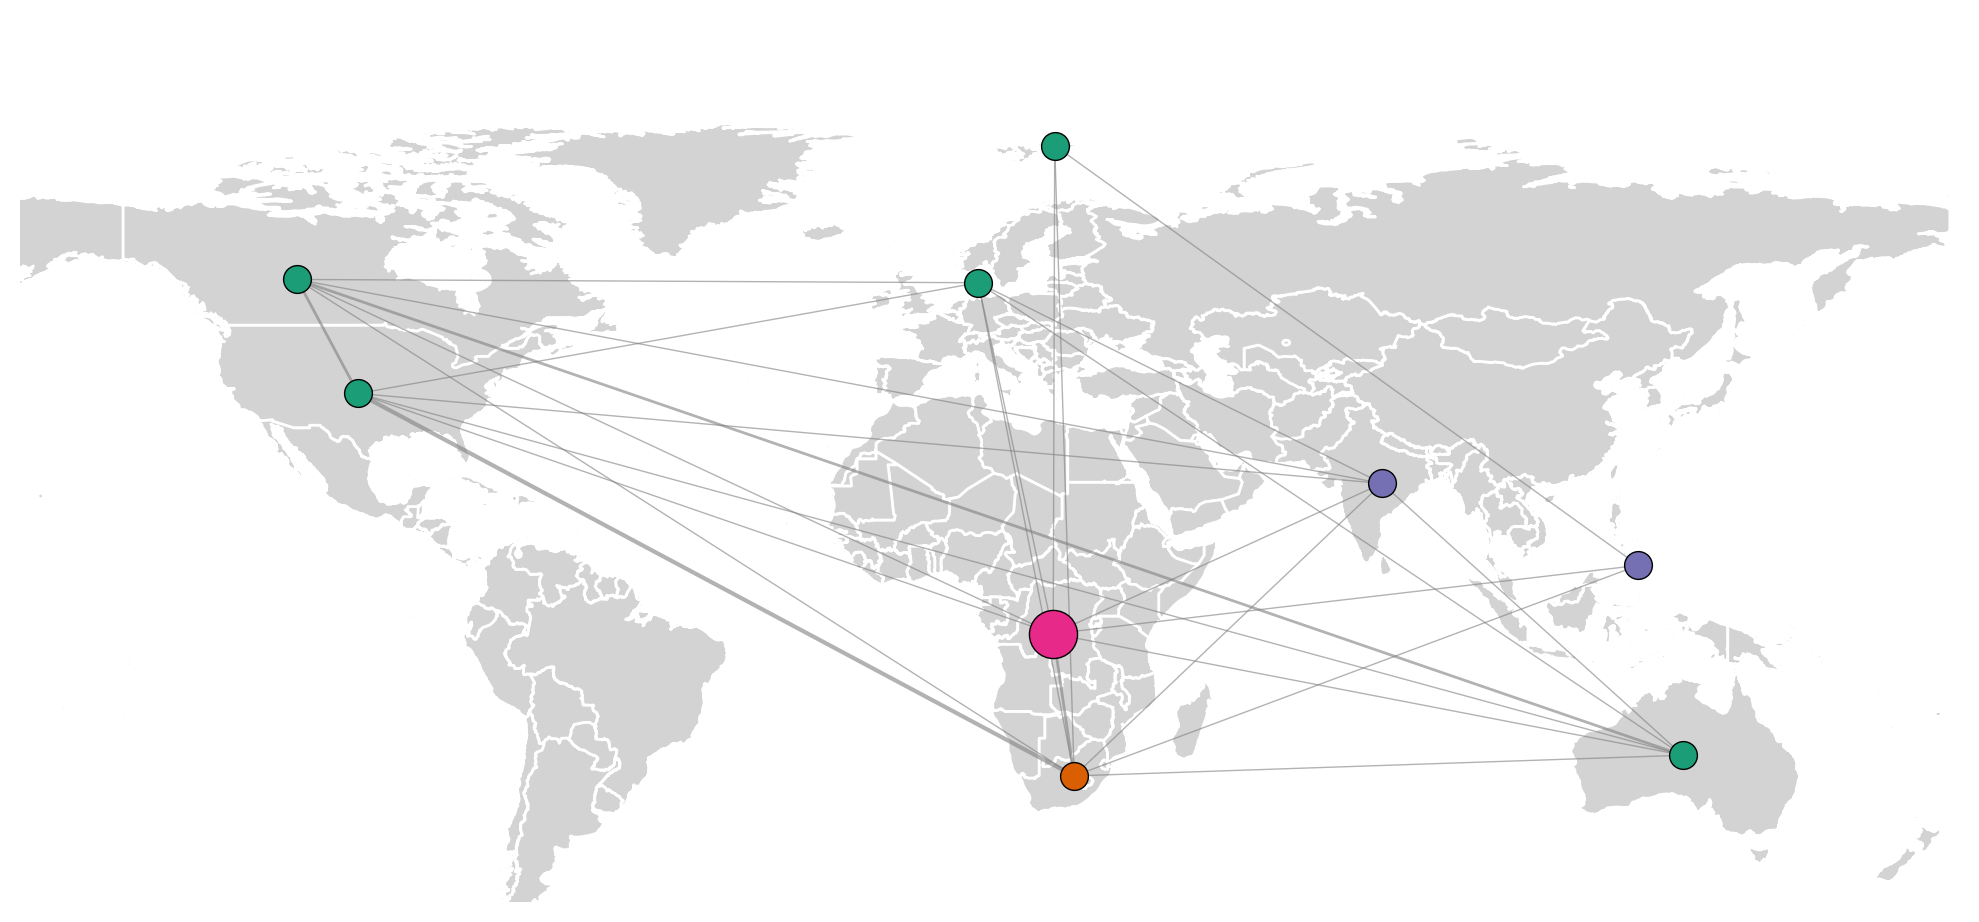

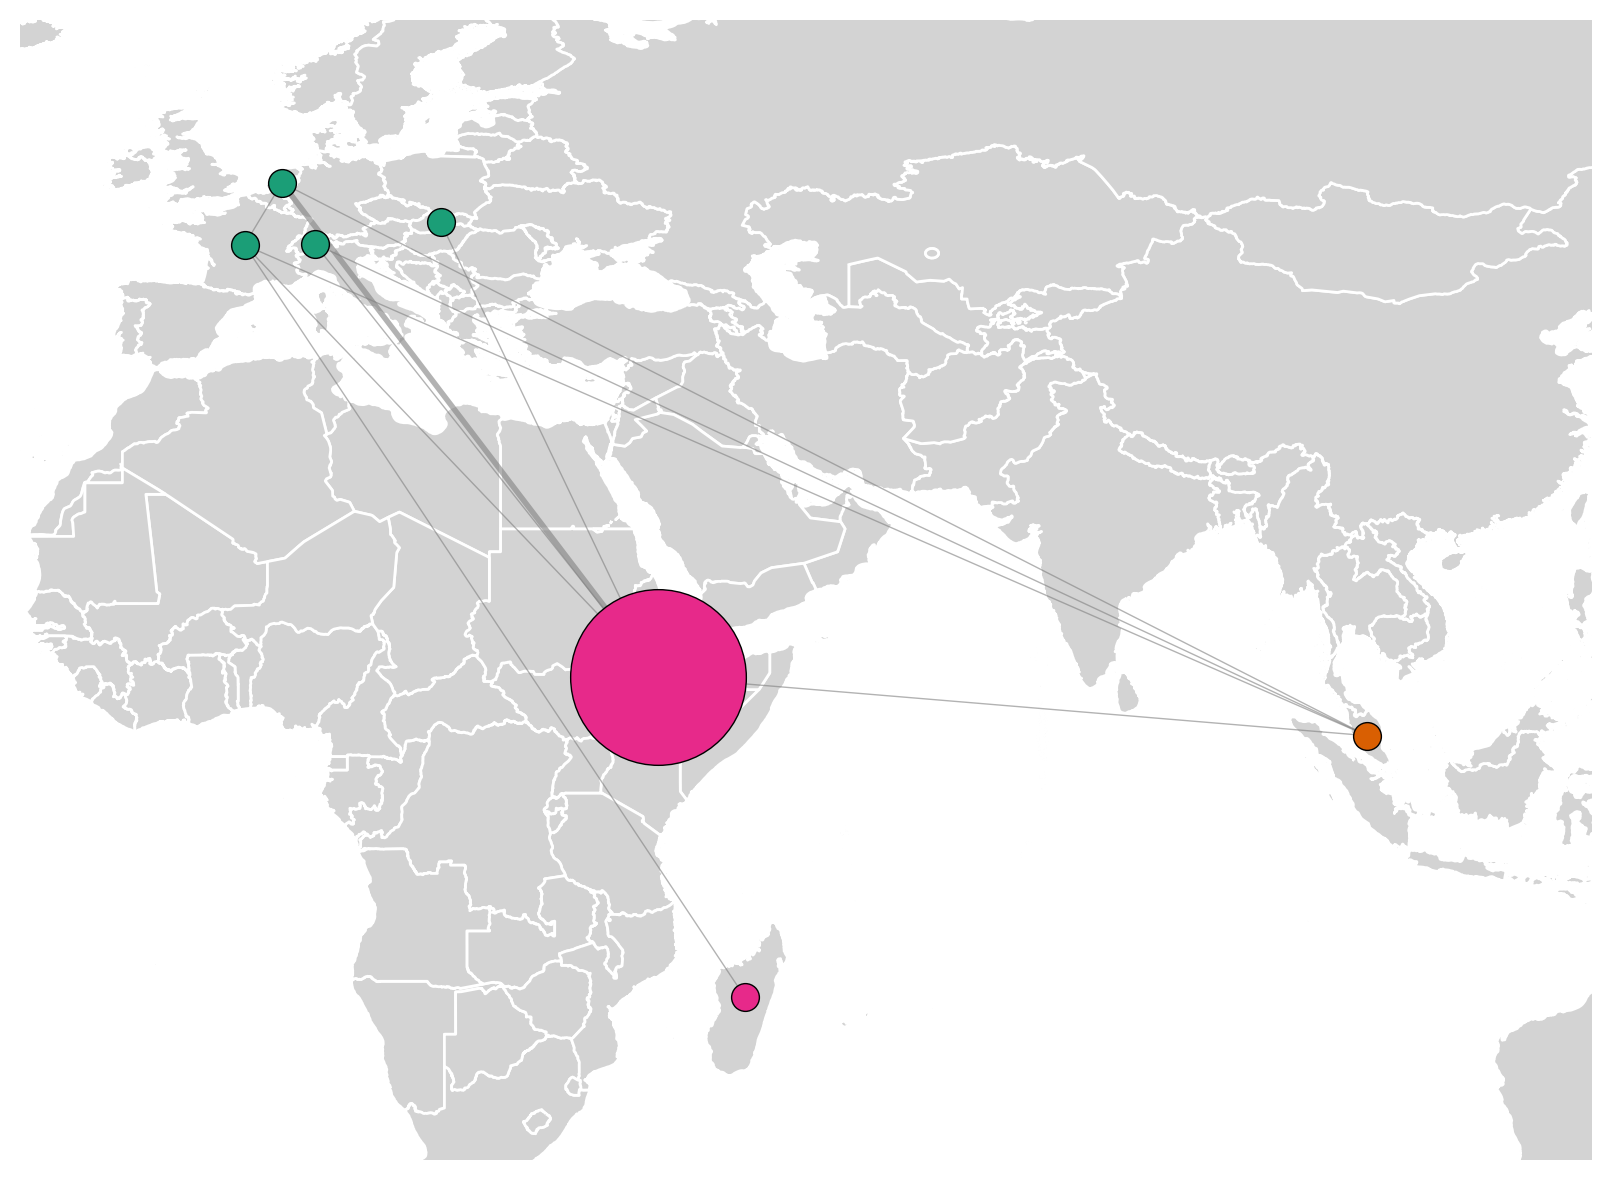

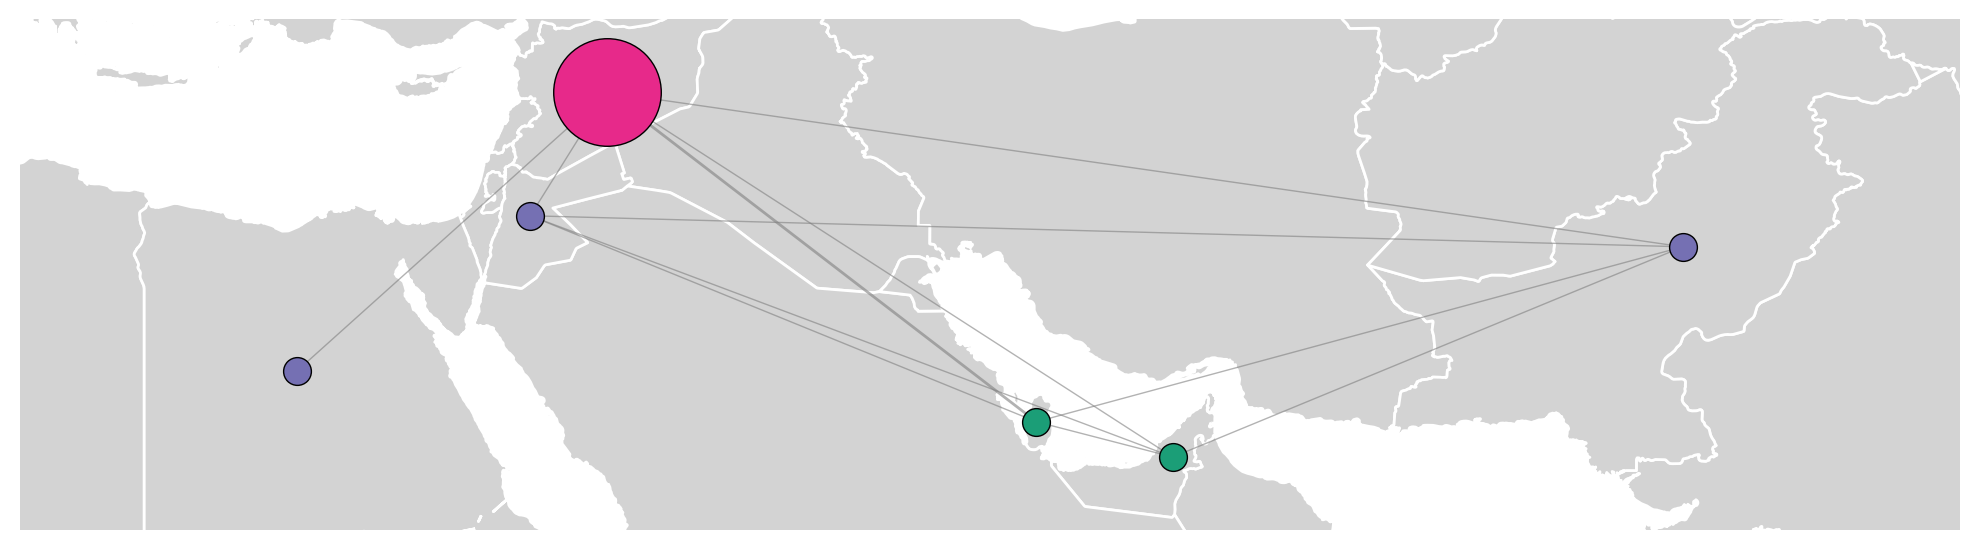

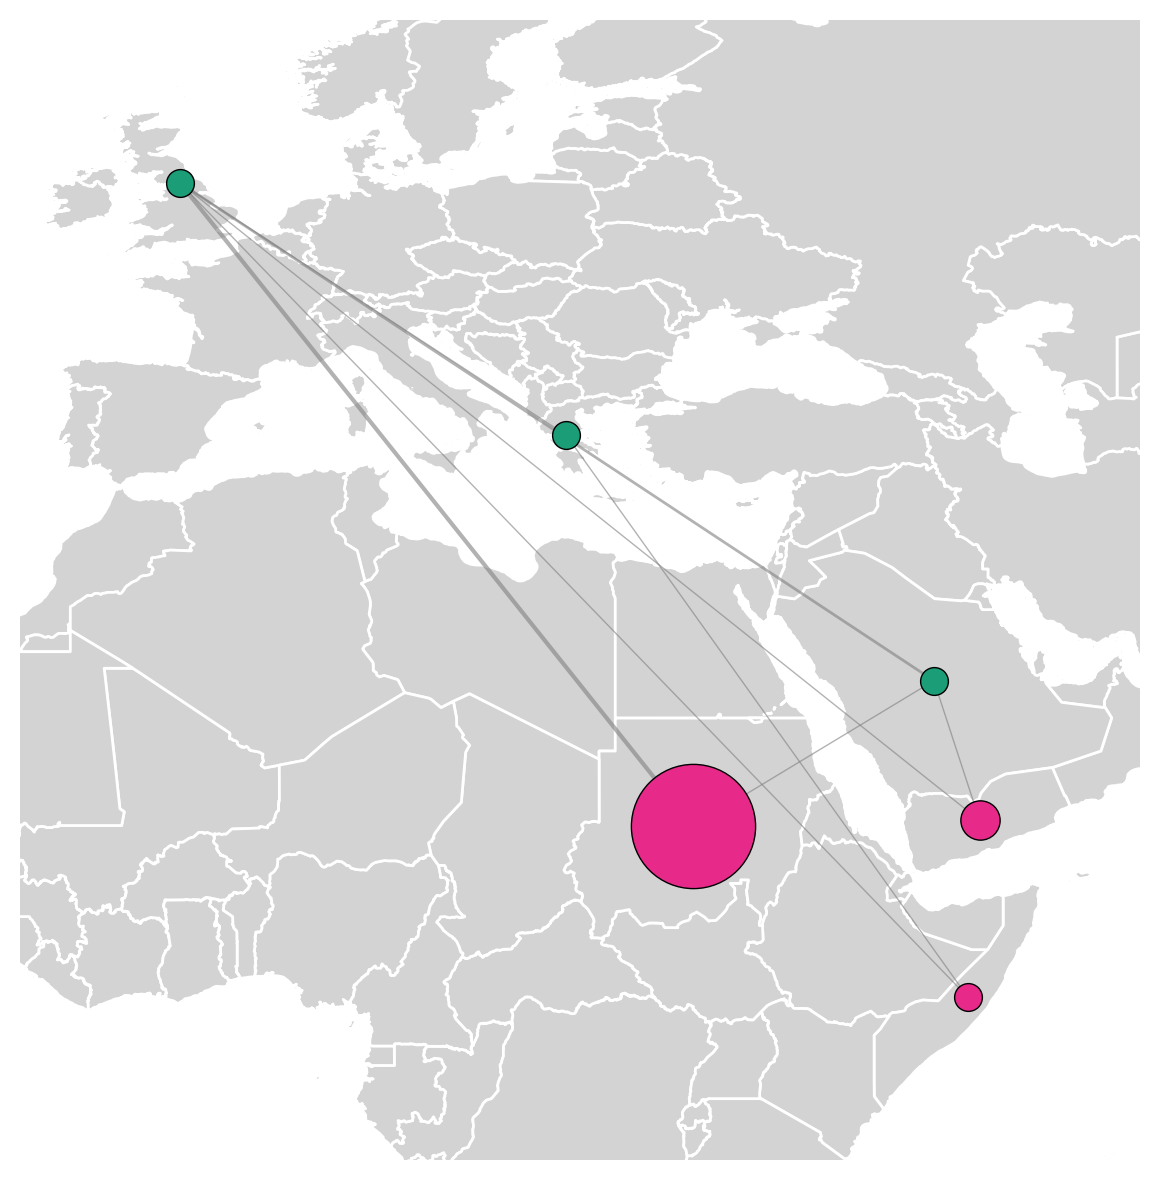

In [203]:
mod_classes = sorted(set(nx.get_node_attributes(G, 'modularity_class').values()))

for mod_class in mod_classes:
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot base world map
    world.plot(ax=ax, color='lightgray', edgecolor='white')
    
    # Get nodes and edges in this cluster
    nodes_in_class = [n for n in G.nodes if G.nodes[n].get('modularity_class') == mod_class]
    sub_edges = [(u, v) for u, v in G.edges if u in nodes_in_class and v in nodes_in_class]

    # Plot edges
    for u, v in sub_edges:
        if u in positions and v in positions:
            x0, y0 = positions[u]
            x1, y1 = positions[v]
            ax.plot([x0, x1], [y0, y1],
                    color='gray',
                    linewidth=G[u][v].get('weight', 1) * 0.5,
                    alpha=0.6,
                    zorder=1)

    # Plot nodes
    for node in nodes_in_class:
        if node in positions:
            x, y = positions[node]
            income = G.nodes[node].get('Income group', 'Other')
            
            # Size: scaled for LICs, fixed for others
            size = G.nodes[node].get('size', 1) * 100 if income == 'Low income' else 100
            color = income_colors.get(income, 'gray')
            
            ax.scatter(x, y,
                       s=size,
                       color=color,
                       edgecolor='black',
                       linewidth=0.5,
                       zorder=2)

    # Auto-zoom to cluster nodes
    cluster_coords = [positions[n] for n in nodes_in_class if n in positions]
    if cluster_coords:
        xs, ys = zip(*cluster_coords)
        padding_x = (max(xs) - min(xs)) * 0.2 or 10
        padding_y = (max(ys) - min(ys)) * 0.2 or 10
        ax.set_xlim(min(xs) - padding_x, max(xs) + padding_x)
        ax.set_ylim(min(ys) - padding_y, max(ys) + padding_y)

    # ax.set_title(f'Modularity Cluster {mod_class}', fontsize=14)
    ax.axis('off')
    
    plt.tight_layout()
    plt.show()

In [ ]:
df = df_foranalyse.copy()

# Define the range of years
years = list(range(2015, 2025))  # From 2015 to 2024
filter_col = 'Year'
node_var = 'Country'
stats_df = pd.DataFrame()

# Step 1: Create networks for each year
for year in years:
    
    stats, _ = create_network(df, filter_col, year, node_var)
    stats_df = pd.concat([stats_df, stats], ignore_index=True)
    print(f"Analysed {year} succesfully.")

# # Step 3: Convert Metrics Data to DataFrame and Display
# clear_output()
print(f"Created a network successfully. Using dataframe for {filter_col} and set the node as {node_var}")
display(stats_df)

In [ ]:
_, G_2024 = create_network(df, "Year", 2024, node_var='Author ID')

nx.write_gexf(G_2024, "coauthorship_2024.gexf")

In [ ]:
# Centrality in 2024
_, G_2024 = create_network(df, "Year", 2024, node_var='Country')

print("Top 10 most influential researchers (by degree centrality):")
print(Counter(nx.degree_centrality(G_2024)).most_common(10))
print("Top 10 most influential researchers (by betweenness centrality):")
print(Counter(nx.betweenness_centrality(G_2024)).most_common(10))
print("Top 10 most influential researchers (by eigenvector centrality):")
print(Counter(nx.eigenvector_centrality(G_2024, max_iter=1000)).most_common(10))

In [ ]:
# Load world map from downloaded Natural Earth dataset
world = gpd.read_file("ne_10m_admin_0_countries.zip")  # Ensure correct path
country_positions = {
    row["ADMIN"]: (row["geometry"].centroid.x, row["geometry"].centroid.y) 
    for _, row in world.iterrows()
}

def correct_graph_nodes(G, country_positions, world):
    """
    Iteratively corrects missing country nodes in the network G by prompting the user
    to input valid country names. Updates G.nodes directly.
    """
    missing_nodes = [node for node in list(G.nodes) if node not in country_positions]

    for node in missing_nodes:
        while node not in country_positions:
            print(f"Missing position for: {node}")
            new_name = input(f"Enter correct country name for '{node}' (or press Enter to skip): ").strip()

            if not new_name:
                print(f"Skipping '{node}'. It won't be plotted.")
                G.remove_node(node)  # Remove node if skipped
                break

            # Check if corrected name exists in GeoPandas world dataset
            matched = world[world["ADMIN"] == new_name]
            if not matched.empty:
                
                # Rename node in the graph (preserves edges)
                nx.relabel_nodes(G, {node: new_name}, copy=False)
                
                # Add position to the updated node
                print(f"Updated '{node}' → '{new_name}'")
                break
            else:
                print(f"'{new_name}' not found in country dataset. Try again.")

def get_continent(country_name):
    row = world[world["ADMIN"] == country_name]
    return row["CONTINENT"].values[0] if not row.empty else "Unknown"

# Define colors for each continent
continent_colors = {
    "Africa": "brown",
    "North America": "blue",
    "South America": "green",
    "Asia": "red",
    "Europe": "purple",
    "Oceania": "orange"
}

# Centrality in 2024
_, G_2024 = create_network(df, "Year", 2024, node_var='Country')
correct_graph_nodes(G_2024, country_positions, world)
clear_output()
G_2024.remove_edges_from(nx.selfloop_edges(G_2024))

In [ ]:
degree_centrality = nx.degree_centrality(G_2024)
betweenness_centrality = nx.betweenness_centrality(G_2024)
closeness_centrality = nx.closeness_centrality(G_2024)

pos = {node: country_positions[node] for node in G_2024.nodes if node in country_positions}
node_sizes = [G_2024.degree(node) * 10 for node in G_2024.nodes]  # Scale factor 10
edge_frequencies = nx.get_edge_attributes(G_2024, "frequency")

if edge_frequencies:  # Check if frequency exists
    max_freq = max(edge_frequencies.values())  # Get max frequency to normalize
    edge_alpha = [0.2 + (G_2024[u][v]["frequency"] / max_freq) * 0.8 for u, v in G_2024.edges]  # Normalize alpha
    edge_widths = [0.5 + (G_2024[u][v]["frequency"] / max_freq) * 10 for u, v in G_2024.edges]  # Scale widths
else:
    edge_alpha = [0.5 for _ in G_2024.edges]  # Default transparency
    edge_widths = [0.5 for _ in G_2024.edges]  # Default width

# Choose one measure for node colors (change this to switch)
centrality_measure = degree_centrality  # You can swap this with degree_centrality or closeness_centrality
centrality_values = np.array(list(centrality_measure.values()))
centrality_norm = (centrality_values - centrality_values.min()) / (centrality_values.max() - centrality_values.min())

# Map to a color palette (choose from 'viridis', 'coolwarm', 'plasma', etc.)
cmap = cm.get_cmap('RdYlGn')
node_color_list = [cmap(value) for value in centrality_norm]  # Get color per node

# Step 3: Plot the Network on a World Map using GeoPandas
fig, ax = plt.subplots(figsize=(12, 8))
world.plot(ax=ax, color="lightgray")  # Draw world map background

# Draw network
nx.draw_networkx_nodes(G_2024, pos, ax=ax, node_size=node_sizes, node_color=node_color_list, alpha=0.9)
nx.draw_networkx_edges(G_2024, pos, ax=ax, edge_color="gray", alpha=edge_alpha, width=0.5)

# Create Colorbar for Centrality
sm = cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=centrality_values.min(), vmax=centrality_values.max()))
cbar = plt.colorbar(sm, ax=ax, fraction=0.02, pad=0.01)
cbar.set_label("Degree Score")

# Set Europe Bounding Box (approximate values)
# ax.set_xlim(-25, 50)  # Longitude limits (Europe)
# ax.set_ylim(30, 75)   # Latitude limits (Europe)

# Title & Display
plt.title(f"Geographic Social Network of Co-Authorship ({year})\nColored by Degree Centrality")
plt.show()

In [ ]:
# Compute centrality measures for the network
degree_centrality = nx.degree_centrality(G_2024)
betweenness_centrality = nx.betweenness_centrality(G_2024)
closeness_centrality = nx.closeness_centrality(G_2024)

# Convert centrality to DataFrame for merging with world map
centrality_df = (
    gpd.GeoDataFrame(
        world, 
        columns=["ADMIN", "geometry"]  # Keep country names & geometries
    )
    .set_index("ADMIN")  # Set country names as index for merging
)

# Add centrality scores (default to 0 if missing)
centrality_df["Degree Centrality"] = centrality_df.index.map(degree_centrality)
centrality_df["Betweenness Centrality"] = centrality_df.index.map(betweenness_centrality)
centrality_df["Closeness Centrality"] = centrality_df.index.map(closeness_centrality)

# Choose centrality to visualize
selected_centrality = "Degree Centrality"  # Change to "Degree Centrality" or "Closeness Centrality"

# Plot the choropleth map
fig, ax = plt.subplots(figsize=(12, 6))
centrality_df.plot(
    column=selected_centrality,
    cmap="RdYlGn",  # Change color scheme if needed
    linewidth=0.8,
    edgecolor="black",
    legend=True,
    legend_kwds={"label": f"{selected_centrality} Score", "shrink": 0.5},  # Adjust legend size
    ax=ax,
    missing_kwds={"color": "white"}
)

# Title & Display
plt.title(f"Geographic Visualization of {selected_centrality} (Co-Authorship Network - {year})")
plt.axis("off")  # Hide axis labels
plt.show()


In [ ]:
df = df_foranalyse.copy()

# Define the range of years
years = list(range(2015, 2025))  # From 2015 to 2024
filter_col = 'Year'
node_var = 'Affiliation'
stats_df = pd.DataFrame()

# Step 1: Create networks for each year
for year in years:
    
    stats, _ = create_network(df, filter_col, year, node_var)
    stats_df = pd.concat([stats_df, stats], ignore_index=True)
    print(f"Analysed {year} succesfully.")

# # Step 3: Convert Metrics Data to DataFrame and Display
# clear_output()
print(f"Created a network successfully. Using dataframe for {filter_col} and set the node as {node_var}")
display(stats_df)

### End

In [ ]:
from itertools import combinations

# Create a function to generate a network for a given year
def create_yearly_network(data, year):
    # Filter data for the given year
    yearly_data = data[data['Year'] == year][['DOI', 'Author(s) ID']].dropna()
    
    # Initialize a graph
    G = nx.Graph()
    
    # Add edges (co-authorships)
    for authors in yearly_data['Author(s) ID']:
        author_list = list(set(authors.split("; ")))  # Ensure unique author IDs & split correctly
        
        for pair in combinations(author_list, 2):  # Generate all pairs of co-authors
            if G.has_edge(*pair):
                G[pair[0]][pair[1]]['weight'] += 1
            else:
                G.add_edge(*pair, weight=1)
    
    return G

def visualize_network(G, title):
    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(G)  # Layout for visualization
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color="blue")
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    nx.draw_networkx_labels(G, pos, font_size=8)
    plt.title(title)
    plt.show()

In [ ]:
# Collect metrics and graphs for visualization
metrics = []
graphs = []

# Loop through each year in the dataset
for year in range(2015, 2025):
    G = create_yearly_network(scopus_df, year)
    graphs.append((G, year))  # Store graph and its year for visualization

    # Check if the graph is connected to calculate metrics requiring a connected graph
    if nx.is_connected(G):
        avg_path_length = nx.average_shortest_path_length(G)
        network_diameter = nx.diameter(G)
    else:
        # Calculate for the largest connected component
        largest_cc = max(nx.connected_components(G), key=len)
        subgraph = G.subgraph(largest_cc)
        avg_path_length = nx.average_shortest_path_length(subgraph)
        network_diameter = nx.diameter(subgraph)

    # Append metrics
    metrics.append({
        "Year": year,
        "Nodes": G.number_of_nodes(),
        "Edges": G.number_of_edges(),
        "Density": nx.density(G),
        "Average Clustering": nx.average_clustering(G),
        "Average Edge per Node": G.number_of_edges() / G.number_of_nodes() if G.number_of_nodes() > 0 else 0,
        "Maximum Edge per Node": max(dict(G.degree()).values()) if G.number_of_nodes() > 0 else 0,
        "Average Path Length": avg_path_length if G.number_of_nodes() > 1 else None,
        "Network Diameter": network_diameter if G.number_of_nodes() > 1 else None
    })
    print(f"Analysis for {year} successfully")
    
print("Analysis completed for all years!")

# # Convert metrics to DataFrame
# import pandas as pd
metrics_df = pd.DataFrame(metrics)
display(metrics_df)

In [ ]:
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm import tqdm


# Load world map from downloaded Natural Earth dataset
world = gpd.read_file("ne_110m_admin_0_countries.zip")  # Update path

# Define colors for each continent
continent_colors = {
    "Africa": "brown",
    "North America": "blue",
    "South America": "green",
    "Asia": "red",
    "Europe": "purple",
    "Oceania": "orange"
}

# Step 2: Create Social Network Graphs with Geographic Mapping
years = list(range(2015, 2025))  # From 2015 to 2024
for year in years:
    G = nx.Graph()

    # Filter data for the given year
    df_year = df[df["Year"] == year]

    # Step 2.1: Add Nodes (Authors with Valid Locations & Continents)
    node_colors = {}

    for row_mapping in df_year["Author ID Mapping with Location"]:
        if isinstance(row_mapping, dict):
            for author_id, details in row_mapping.items():
                lat, lon = details.get("Latitude"), details.get("Longitude")
                affiliation = details.get("Affiliation")
                country = details.get("Country")
                continent = details.get("Continent")

                if lat is not None and lon is not None:  # Ensure valid coordinates
                    G.add_node(author_id, pos=(lon, lat), continent=continent)  # (longitude, latitude)
                    node_colors[author_id] = continent_colors.get(continent, "gray")  # Assign color

    # Step 2.2: Add Edges (Co-authorships)
    for row_mapping in df_year["Author ID Mapping with Location"]:
        if isinstance(row_mapping, dict):
            author_ids = [author_id for author_id in row_mapping.keys() if author_id in G.nodes]

            for i in range(len(author_ids)):
                for j in range(i + 1, len(author_ids)):
                    G.add_edge(author_ids[i], author_ids[j])

    # Step 3: Plot the Network on a World Map using GeoPandas
    fig, ax = plt.subplots(figsize=(12, 8))
    world.plot(ax=ax, color="lightgray")  # Draw world map background

    # Get node positions (valid locations only)
    pos = {node: G.nodes[node]["pos"] for node in G.nodes}

    # Draw network with colored nodes
    node_color_list = [node_colors[node] for node in G.nodes]  # Convert dict to list of colors

    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=30, node_color=node_color_list, alpha=0.8)
    nx.draw_networkx_edges(G, pos, ax=ax, edge_color="gray", alpha=0.5, width=0.5)

    # Create legend for continents
    legend_labels = {continent: plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10)
                     for continent, color in continent_colors.items()}
    plt.legend(legend_labels.values(), legend_labels.keys(), title="Continent", loc="best")

    # Title & Display
    plt.title(f"Geographic Social Network of Co-Authorship {year}")
    plt.show()


In [ ]:
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Step 2: Create Social Network Graphs with Geographic Mapping
for journal in df['Source title'].unique():
    G = nx.Graph()

    # Filter data for the given year
    df_year = df[df["Source title"] == journal]

    # Step 2.1: Add Nodes (Authors with Valid Locations & Continents)
    node_colors = {}

    for row_mapping in df_year["Author ID Mapping with Location"]:
        if isinstance(row_mapping, dict):
            for author_id, details in row_mapping.items():
                lat, lon = details.get("Latitude"), details.get("Longitude")
                affiliation = details.get("Affiliation")
                country = details.get("Country")
                continent = details.get("Continent")

                if lat is not None and lon is not None:  # Ensure valid coordinates
                    G.add_node(author_id, pos=(lon, lat), continent=continent)  # (longitude, latitude)
                    node_colors[author_id] = continent_colors.get(continent, "gray")  # Assign color

    # Step 2.2: Add Edges (Co-authorships)
    for row_mapping in df_year["Author ID Mapping with Location"]:
        if isinstance(row_mapping, dict):
            author_ids = [author_id for author_id in row_mapping.keys() if author_id in G.nodes]

            for i in range(len(author_ids)):
                for j in range(i + 1, len(author_ids)):
                    G.add_edge(author_ids[i], author_ids[j])

    # Step 3: Plot the Network on a World Map using GeoPandas
    fig, ax = plt.subplots(figsize=(12, 8))
    world.plot(ax=ax, color="lightgray")  # Draw world map background

    # Get node positions (valid locations only)
    pos = {node: G.nodes[node]["pos"] for node in G.nodes}

    # Draw network with colored nodes
    node_color_list = [node_colors[node] for node in G.nodes]  # Convert dict to list of colors

    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=30, node_color=node_color_list, alpha=0.8)
    nx.draw_networkx_edges(G, pos, ax=ax, edge_color="gray", alpha=0.5, width=0.5)

    # Create legend for continents
    legend_labels = {continent: plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10)
                     for continent, color in continent_colors.items()}
    plt.legend(legend_labels.values(), legend_labels.keys(), title="Continent", loc="best")

    # Title & Display
    plt.title(f"Geographic Social Network of Co-Authorship {journal}")
    plt.show()

In [ ]:
# Collect metrics and graphs for visualization
metrics = []
graphs = []

# Loop through each year in the dataset
for year in range(2015, 2025):
    G = create_yearly_network(scopus_df, year)
    graphs.append((G, year))  # Store graph and its year for visualization

    # Check if the graph is connected to calculate metrics requiring a connected graph
    if nx.is_connected(G):
        avg_path_length = nx.average_shortest_path_length(G)
        network_diameter = nx.diameter(G)
    else:
        # Calculate for the largest connected component
        largest_cc = max(nx.connected_components(G), key=len)
        subgraph = G.subgraph(largest_cc)
        avg_path_length = nx.average_shortest_path_length(subgraph)
        network_diameter = nx.diameter(subgraph)

    # Append metrics
    metrics.append({
        "Year": year,
        "Nodes": G.number_of_nodes(),
        "Edges": G.number_of_edges(),
        "Density": nx.density(G),
        "Average Clustering": nx.average_clustering(G),
        "Average Edge per Node": G.number_of_edges() / G.number_of_nodes() if G.number_of_nodes() > 0 else 0,
        "Maximum Edge per Node": max(dict(G.degree()).values()) if G.number_of_nodes() > 0 else 0,
        "Average Path Length": avg_path_length if G.number_of_nodes() > 1 else None,
        "Network Diameter": network_diameter if G.number_of_nodes() > 1 else None
    })
    print(f"Analysis for {year} successfully")
    
print("Analysis completed for all years!")

# # Convert metrics to DataFrame
# import pandas as pd
metrics_df = pd.DataFrame(metrics)
display(metrics_df)

# # Visualize Networks in Subplots
# import matplotlib.pyplot as plt

# def visualize_networks_subplots(networks):
#     """
#     Visualize multiple networks in subplots (2 rows x 5 columns).
#     """
#     fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 rows, 5 columns
#     axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

#     for i, (G, year) in enumerate(networks):
#         ax = axes[i]
#         pos = nx.spring_layout(G)  # Layout for visualization
#         nx.draw_networkx_nodes(G, pos, ax=ax, node_size=50, node_color="blue")
#         nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.3)
#         ax.set_title(f"Network {year}")
#         ax.axis("off")  # Turn off axis display

#     # Turn off unused subplots if there are fewer than 10 networks
#     for i in range(len(networks), len(axes)):
#         axes[i].axis("off")

#     plt.tight_layout()
#     plt.show()

# # Call the subplot visualization
# visualize_networks_subplots(graphs)

In [ ]:
# Plot temporal trends
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Year'], metrics_df['Nodes'], label='Nodes')
plt.plot(metrics_df['Year'], metrics_df['Edges'], label='Edges')
plt.plot(metrics_df['Year'], metrics_df['Density'], label='Density')
plt.title("Temporal Trends in Co-Authorship Network")
plt.xlabel("Year")
plt.ylabel("Metric Value")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Set up the figure for subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(30, 10))  # Adjust rows/cols for 10 years (2015-2024)
axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

# Loop through each year and plot the degree centrality distribution
for i, year in enumerate(range(2015, 2025)):
    G = create_yearly_network(scopus_df, year)  # Create network for the year
    centrality_over_time = nx.degree_centrality(G)  # Calculate degree centrality
    
    # Plot on the corresponding subplot
    axes[i].hist(centrality_over_time.values(), bins=20, edgecolor='k')
    axes[i].set_title(f"Degree Centrality Distribution ({year})")
    axes[i].set_xlabel("Degree Centrality")
    axes[i].set_ylabel("Frequency")

# Adjust layout to avoid overlapping
plt.tight_layout()

# Show the full figure
plt.show()

In [ ]:
import community as community_louvain  # Requires `python-louvain`

G_2015 = create_yearly_network(df, 2015)

# Function to detect communities
def detect_communities(G):
    # Apply Louvain community detection
    partition = community_louvain.best_partition(G)
    return partition

# Example: Detect communities for 2015
partition_2015 = detect_communities(G_2015)

# Visualize the network with communities
def visualize_communities(G, partition, title):
    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(G)
    cmap = plt.cm.tab10
    # Draw nodes with community colors
    nx.draw_networkx_nodes(G, pos, node_size=50, cmap=cmap, 
                           node_color=[partition[node] for node in G.nodes()])
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    plt.title(title)
    plt.show()

visualize_communities(G_2015, partition_2015, "Communities in Co-Authorship Network (2015)")

In [ ]:
# Set your email to comply with NCBI policies
Entrez.email = "peerasitsitthirat@gmail.com"

# Function to fetch metadata with ORCID
def fetch_metadata_with_orcid(pmids, output_csv="authors_affiliations_orcid.csv", checkpoint_file="checkpoint.txt"):
    data = []  # List to store metadata
    start_index = 0  # Default starting index

    # Check if a checkpoint exists to resume the process
    if os.path.exists(checkpoint_file):
        with open(checkpoint_file, "r") as f:
            start_index = int(f.read().strip())  # Read the last processed index
        print(f"Resuming from index {start_index}...")

    # Process PMIDs from the start_index onward
    for idx, pmid in enumerate(tqdm(pmids[start_index:], desc="Processing PMIDs"), start=start_index):
        try:
            # Fetch the metadata from PubMed
            handle = Entrez.efetch(db="pubmed", id=pmid, rettype="xml", retmode="text")
            records = Entrez.read(handle)
            handle.close()

            # Extract authors, affiliations, and ORCID
            article = records["PubmedArticle"][0]
            if "AuthorList" in article["MedlineCitation"]["Article"]:
                
                i = 0
                
                for author in article["MedlineCitation"]["Article"]["AuthorList"]:
                    
                    if i == 0:
                        is_firstauthor = True
                    else:
                        is_firstauthor = False
                    
                    # Safely extract ForeName and LastName
                    fname = author["ForeName"] if "ForeName" in author and author["ForeName"] else ""
                    lname = author["LastName"] if "LastName" in author and author["LastName"] else ""
                    initial = author["Initials"] if "Initials" in author and author["Initials"] else ""

                    # Safely handle Identifier (like ORCID)
                    iden = None
                    if "Identifier" in author and author["Identifier"]:  # Ensure Identifier exists and is not empty
                        iden = str(author["Identifier"][0])  # Convert to string to get the ORCID or other ID
                    else:
                        iden = None

                    # Safely handle AffiliationInfo
                    aff = None
                    if "AffiliationInfo" in author and author["AffiliationInfo"]:  # Ensure AffiliationInfo exists and is not empty
                        aff = author["AffiliationInfo"][0].get("Affiliation", "No affiliation")
                    else:
                        aff = None
                    
                    i += 1

                    # Append author metadata to results
                    data.append({
                        "PMID": pmid,
                        "Full Name": f"{lname} {fname}",
                        "Initials": f"{lname} {initial}",
                        "Abbrev": f"{lname[:1]}{initial}",
                        "ORCID": iden,
                        "Affiliation": aff,
                        "First Author": is_firstauthor
                    })
            else:
                # Handle case where no authors are found
                data.append({
                    "PMID": pmid,
                    "Full Name": None,
                    "Initials": None,
                    "Abbrev": None,
                    "ORCID": None,
                    "Affiliation": None,
                    "First Author": None
                })
        except Exception as e:
            # Handle any exceptions gracefully
            print(f"Error fetching data for PMID {pmid}: {e}")
            data.append({
                "PMID": pmid, 
                "Full Name": "Error", 
                "Initials": "Error",
                "Abbrev": "Error",
                "ORCID": "N/A",
                "Affiliation": str(e),
                "First Author": "N/A"
            })

        # Save progress every 100 PMIDs
        if (idx + 1) % 100 == 0:
            # Append to CSV file
            pd.DataFrame(data).to_csv(output_csv, mode="a", index=False, header=not os.path.exists(output_csv))
            data.clear()  # Clear the data list to save memory

            # Save the current index to the checkpoint file
            with open(checkpoint_file, "w") as f:
                f.write(str(idx + 1))

    # Save any remaining data after the loop
    if data:
        pd.DataFrame(data).to_csv(output_csv, mode="a", index=False, header=not os.path.exists(output_csv))

    # Remove the checkpoint file when processing is complete
    if os.path.exists(checkpoint_file):
        os.remove(checkpoint_file)

    print(f"Processing complete. Results saved to {output_csv}.")

In [ ]:
# Example usage
pmid_list = df['PMID'].to_list()
fetch_metadata_with_orcid(pmid_list)

In [ ]:
# Split the Authors column into individual rows, associating each with its PMID
authors_data = df[['PMID', 'Authors']].copy()
authors_data['Authors'] = authors_data['Authors'].str.replace('.', '', regex=False)  # Remove periods from author names

# Split authors into multiple rows for each PMID
authors_split = authors_data.set_index('PMID').Authors.str.split(', ').explode().reset_index()

# Rename columns for clarity
authors_split.columns = ['PMID', 'Author Name']
authors_split['Is First Author'] = authors_split.groupby('PMID').cumcount() == 0

display(authors_split)

In [ ]:
# Create edges based on PMID
edges = []
for pmid, group in authors_split.groupby('PMID'):
    authors = group['Author Name'].tolist()
    for i in range(len(authors)):
        for j in range(i + 1, len(authors)):
            edges.append({
                "Author_1": authors[i], 
                "Author_2": authors[j]
                })

edges_df = pd.DataFrame(edges)

plt.figure(figsize = (200,200))
G = nx.from_pandas_edgelist(edges_df, 'Author_1', 'Author_2', create_using=nx.Graph())
nx.draw(G, with_labels=False, node_size=500, width=20)

# # Create the graph
# G = nx.Graph()
# G.add_edges_from(edges)

# # Plot the graph
# plt.figure(figsize=(12, 10))
# pos = nx.spring_layout(G, seed=42)  # Layout for visualization
# nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=10)
# nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.6)
# plt.title("Co-Authorship Network", fontsize=16)
# plt.show()

In [ ]:
affiliation_df = pd.read_csv('data/affiliations.csv')
# affiliation_df = affiliation_df.drop_duplicates(keep='first')
display(affiliation_df)

# print(len(df['PMID'].unique()), len(affiliation_df['PMID'].unique()))